In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import dask.array as da
import cftime
import scipy as scipy

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

def update_leads(x):
    """Converts from time coordinates to lead coordinates.
    I.e., lead days.
    """
    x = x.rename({"time": "lead"})
    x = x.assign_coords(lead=np.arange(x.lead.size).astype(int))
    
    return x

def drop_duplicates_along_all_dims(obj, keep=False):
    deduplicated = obj
    for dim in obj.dims:
        indexes = {dim: ~deduplicated.get_index(dim).duplicated(keep=keep)}
        deduplicated = deduplicated.isel(indexes)
    return deduplicated

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="02:00:00",
    account="P93300041",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(8)
client.wait_for_workers(8)


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44343 instead
  warnings.warn(


In [5]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


## Read in simulations

In [6]:
def get_fcstDS(dataDir, init):
    # init = fcst_init[iFcst]
    filelist = np.sort(glob.glob(dataDir+'*'+init+'_00z_d01_d46*.nc'))

    # Open all ensemble members for a given init.
    ds = xr.open_mfdataset(
        filelist,
        combine="nested",
        parallel=True,
        concat_dim="member",
        preprocess=drop_duplicates_along_all_dims,
        chunks = {"time": -1, "lon": -1, "lat": -1},
        # speeds things up a bit
        coords="minimal",
        compat="override",
    ).rename({"time": "lead"})

    # Derive datetime for initialization based on the string in the filename.
    MON_TO_INT = {
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12,
    }

    day = init[0:2]
    mon = init[2:5]
    mon = MON_TO_INT[mon]
    year = init[5::]

    # Assign initialization year and member numbers as coordinates.
    ds = ds.assign_coords(
        lead=np.arange(ds.lead.size).astype(int),
        init=cftime.DatetimeNoLeap(int(year), int(mon), int(day)),
        member=np.arange(ds[var].shape[0]) + 1,
#        member=np.arange(5) + 1,
    )

    # Chunk into one chunk. About 100MB per initialization
    # (full globe, all leads, all members)
    ds = ds.chunk({"member": -1})

    return ds


In [7]:
dataDir_jun = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2012/06/'
dataDir_jul = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2012/07/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
             '02jul2012',
            ]
var = 'tas_2m'


ds_0611 = get_fcstDS(dataDir_jun, fcst_init[0])
ds_0618 = get_fcstDS(dataDir_jun, fcst_init[1])
ds_0625 = get_fcstDS(dataDir_jun, fcst_init[2])
ds_0702 = get_fcstDS(dataDir_jul, fcst_init[3])


### Get cases with different coupling strenght

In [12]:
dataDir_0p5 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land0.5/p1/tas_2m/2012/06/'
dataDir_1p0 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land1.0/p1/tas_2m/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'tas_2m'

tas_0p5_0611 = get_fcstDS(dataDir_0p5, fcst_init[0])
tas_0p5_0618 = get_fcstDS(dataDir_0p5, fcst_init[1])
tas_0p5_0625 = get_fcstDS(dataDir_0p5, fcst_init[2])

tas_1p0_0611 = get_fcstDS(dataDir_1p0, fcst_init[0])
tas_1p0_0618 = get_fcstDS(dataDir_1p0, fcst_init[1])
tas_1p0_0625 = get_fcstDS(dataDir_1p0, fcst_init[2])


In [15]:
tas_0p5_0611

<xarray.Dataset> Size: 252MB
Dimensions:  (member: 21, lead: 46, lat: 181, lon: 360)
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lead     (lead) int64 368B 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45
    init     object 8B 2012-06-11 00:00:00
  * member   (member) int64 168B 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
Data variables:
    tas_2m   (member, lead, lat, lon) float32 252MB dask.array<chunksize=(21, 46, 181, 360), meta=np.ndarray>

### Get obs

In [ ]:
era5_dir = '/glade/campaign/collections/rda/data/d633000/e5.oper.an.sfc/'
junFile = glob.glob(era5_dir+'201206/'+'*_2t.*')
julFile = glob.glob(era5_dir+'201207/'+'*_2t.*')

junDS = xr.open_dataset(junFile[0], decode_times=True)
julDS = xr.open_dataset(julFile[0], decode_times=True)
# era5_2mT = xr.concat([junDS, julDS], dim='time')
era5_2mT = xr.concat([junDS, julDS], dim='time').sel(latitude=slice(60,10), longitude=slice(200,300))

era5_2mT = era5_2mT.resample(time='1D').mean(dim='time')


## Regrid 
era5_2mT = era5_2mT.rename({'longitude': 'lon','latitude': 'lat'})
regrid_era5_2mT = regrid_data(era5_2mT, climo_0611.sel(lat=slice(60,10), lon=slice(200,300)), method=1)



**Get climo**

In [8]:
model = "CESM2"
data = "climatology" #raw or anom or climatology

hinda = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+"."+data+".daily.geospatial.zarr/", consolidated=True).astype('float32')
hinda["lead"] = range(0,46)

In [9]:
# Select climo for each start date
climo_0611 = hinda.sel(dayofyear=162)
climo_0618 = hinda.sel(dayofyear=169)
climo_0625 = hinda.sel(dayofyear=176)
climo_0702 = hinda.sel(dayofyear=183)


In [10]:
## - - - Get anomalies - - - 

# regrid first? 
regrid_ds_0611 = regrid_data(ds_0611.reindex(lat=list(reversed(ds_0611.lat))), climo_0611, method=1)
regrid_ds_0618 = regrid_data(ds_0618.reindex(lat=list(reversed(ds_0618.lat))), climo_0618, method=1)
regrid_ds_0625 = regrid_data(ds_0625.reindex(lat=list(reversed(ds_0625.lat))), climo_0625, method=1)
regrid_ds_0702 = regrid_data(ds_0702.reindex(lat=list(reversed(ds_0702.lat))), climo_0702, method=1)

# Compute actual anomalies
anom_0611 = regrid_ds_0611['tas_2m'] - climo_0611['t2m']
anom_0618 = regrid_ds_0618['tas_2m'] - climo_0618['t2m']
anom_0625 = regrid_ds_0625['tas_2m'] - climo_0625['t2m']
anom_0702 = regrid_ds_0702['tas_2m'] - climo_0702['t2m']

anom_0611_ensMean = anom_0611.mean(dim='member')
anom_0618_ensMean = anom_0618.mean(dim='member')
anom_0625_ensMean = anom_0625.mean(dim='member')
anom_0702_ensMean = anom_0702.mean(dim='member')


In [175]:
# A little paranoid about climoLND... 

model = "CESM2_climoLND"
data = "climatology" #raw or anom or climatology

hindaLND = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+"."+data+".daily.geospatial.zarr/", consolidated=True).astype('float32')
hindaLND["lead"] = range(0,46)


In [176]:
# Select climo for each start date
climoLNDclimo_0611 = hindaLND.sel(dayofyear=162)
climoLNDclimo_0618 = hindaLND.sel(dayofyear=169)
climoLNDclimo_0625 = hindaLND.sel(dayofyear=176)
climoLNDclimo_0702 = hindaLND.sel(dayofyear=183)


In [178]:
# A little paranoid about climoLND... 

model = "cesm2cam6climoOCNclimoATM"
data = "climatology" #raw or anom or climatology

hindaATMOCN = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/"+model+"."+data+".daily.TREFHT.geospatial.zarr/", consolidated=True).astype('float32')
hindaATMOCN["lead"] = range(0,46)


In [179]:
# Select climo for each start date
climoATMOCNclimo_0611 = hindaATMOCN.sel(dayofyear=162)
climoATMOCNclimo_0618 = hindaATMOCN.sel(dayofyear=169)

## Get observations?

In [12]:
era5_dir = '/glade/campaign/collections/rda/data/d633000/e5.oper.an.sfc/'
junFile = glob.glob(era5_dir+'201206/'+'*_2t.*')
julFile = glob.glob(era5_dir+'201207/'+'*_2t.*')

junDS = xr.open_dataset(junFile[0], decode_times=True)
julDS = xr.open_dataset(julFile[0], decode_times=True)
# era5_2mT = xr.concat([junDS, julDS], dim='time')
era5_2mT = xr.concat([junDS, julDS], dim='time').sel(latitude=slice(60,10), longitude=slice(200,300))


In [13]:
era5_2mT = era5_2mT.resample(time='1D').mean(dim='time')

In [14]:
## Regrid 
era5_2mT = era5_2mT.rename({'longitude': 'lon','latitude': 'lat'})
regrid_era5_2mT = regrid_data(era5_2mT, climo_0611.sel(lat=slice(60,10), lon=slice(200,300)), method=1)


In [15]:
## How do I get a long-term climo to remove... read in all the june/july??

In [16]:
# Want to get a climatology of summer to remove 
mayFiles_1990s = np.sort(glob.glob(era5_dir+'199?05/'+'*_2t.*'))
mayFiles_2000s = np.sort(glob.glob(era5_dir+'20??05/'+'*_2t.*'))
mayFiles_all = np.concatenate((mayFiles_1990s,mayFiles_2000s))

junFiles_1990s = np.sort(glob.glob(era5_dir+'199?06/'+'*_2t.*'))
junFiles_2000s = np.sort(glob.glob(era5_dir+'20??06/'+'*_2t.*'))
juneFiles_all = np.concatenate((junFiles_1990s,junFiles_2000s))

julFiles_1990s = np.sort(glob.glob(era5_dir+'199?07/'+'*_2t.*'))
julFiles_2000s = np.sort(glob.glob(era5_dir+'20??07/'+'*_2t.*'))
julyFiles_all = np.concatenate((julFiles_1990s, julFiles_2000s))

augFiles_1990s = np.sort(glob.glob(era5_dir+'199?08/'+'*_2t.*'))
augFiles_2000s = np.sort(glob.glob(era5_dir+'20??08/'+'*_2t.*'))
augFiles_all = np.concatenate((augFiles_1990s, augFiles_2000s))

merge_files = np.sort(np.concatenate((mayFiles_all, juneFiles_all, julyFiles_all, augFiles_all)))

def preprocess_era5(DS):
    DS = DS.sel(latitude=slice(60,10), longitude=slice(200,300)).resample(time='1D').mean(dim='time')
    return DS

era5_allJJ = xr.open_mfdataset(merge_files, preprocess=preprocess_era5)



In [17]:
era5_allJJ = era5_allJJ.rename({'longitude': 'lon','latitude': 'lat'})

In [18]:
# Regrid to match CAM grid
era5_allJJ_regrid = regrid_data(era5_allJJ, climo_0611.sel(lat=slice(60,10), lon=slice(200,300)), method=1)

In [19]:
## Compute climo and anomalies 
var = ['VAR_2T'] 
da_day_clim_smooth_vars = []

for i in var:
    print(i)
    da_day_clim = era5_allJJ_regrid[i].groupby("time.dayofyear").mean("time")
    days = da_day_clim.shape[0]
    # Rechunk to make dayofyear climatology one chunk.
    da_day_clim = da_day_clim.chunk({"dayofyear": days}).persist()
    # Just mimicking the chunk sizes from our climatology.
    x = da.full((days, da_day_clim.lat.size, da_day_clim.lon.size),
        # np.nan,dtype="float32",chunks=(days, 181, 360))
        np.nan,dtype="float32",chunks=(days, da_day_clim.lat.size, da_day_clim.lon.size))
    # Pad the daily climatolgy with nans
    _da = xr.DataArray(x,dims=["dayofyear", "lat", "lon"],
        coords=[da_day_clim.dayofyear, da_day_clim.lat, da_day_clim.lon],name=i,)
    # Pad the daily climatolgy with nans
    da_day_clim_wnan = da_day_clim.combine_first(_da)
    # Period rolling twice to make it triangular smoothing
    da_day_clim_smooth = da_day_clim_wnan.copy()
    
    for j in range(2):
        # Extand the DataArray to allow rolling to do periodic
        da_day_clim_smooth = xr.concat([da_day_clim_smooth[-15:], da_day_clim_smooth, da_day_clim_smooth[:15]],"dayofyear",)
        # Rolling mean
        da_day_clim_smooth = da_day_clim_smooth.rolling(dayofyear=31, center=True, min_periods=1).mean()
        # Drop the periodic boundaries
        da_day_clim_smooth = da_day_clim_smooth.isel(dayofyear=slice(15, -15))
        
    # Extract the original days
    da_day_clim_smooth = da_day_clim_smooth.sel(dayofyear=da_day_clim.dayofyear)
    da_day_clim_smooth.name = i
    
    da_day_clim_smooth_vars.append(da_day_clim_smooth)

# era5_climo = era5_allJJ_regrid.groupby("time.dayofyear").mean("time")


VAR_2T


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/client.py:3245: UserWarning: Sending large graph of size 60.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [20]:
clim = xr.merge(da_day_clim_smooth_vars)

In [151]:
## Get actual anomaly? 
ds_anom = regrid_era5_2mT.groupby("time.dayofyear") - clim

In [22]:
ds_anom.compute()

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 61, lat: 34, lon: 67)
Coordinates:
  * time       (time) datetime64[ns] 488B 2012-06-01 2012-06-02 ... 2012-07-31
  * lat        (lat) float64 272B 60.0 58.5 57.0 55.5 ... 15.0 13.5 12.0 10.5
  * lon        (lon) float64 536B 201.0 202.5 204.0 205.5 ... 297.0 298.5 300.0
    dayofyear  (time) int64 488B 153 154 155 156 157 158 ... 209 210 211 212 213
Data variables:
    VAR_2T     (time, lat, lon) float64 1MB -2.314 -1.417 ... 0.6455 -0.1642

In [152]:
era5_2T_anom = ds_anom

In [26]:
## Plot weekly means?

In [69]:
longrid_anom, latgrid_anom = np.meshgrid(ds_anom['lon'], ds_anom['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-6, vmax=6)

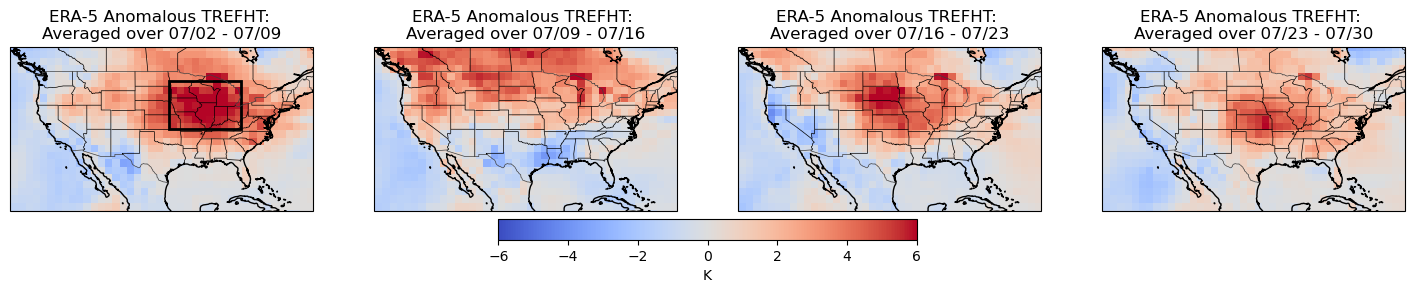

In [75]:
fig,axs = plt.subplots(1,4, figsize=(18,4),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

iStart    = 31
startDate = datetime.datetime(ds_anom['time.year'].values[iStart], ds_anom['time.month'].values[iStart], ds_anom['time.day'].values[iStart])

for iWeek in range(4): 
    selDS_thisWeek = ds_anom.VAR_2T.isel(time=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='time').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('ERA-5 Anomalous TREFHT: '+
                         '\nAveraged over '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

# Add rectangle?
axs[0].add_patch(patches.Rectangle(xy=[263, 37], width=(278-263), height=(47-37),
                                facecolor='none', edgecolor='k',linestyle='-',
                                linewidth=2, transform=ccrs.PlateCarree()))


## Make some analysis plots!

In [174]:
longrid_anom, latgrid_anom = np.meshgrid(anom_0611['lon'], anom_0611['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-6, vmax=6)

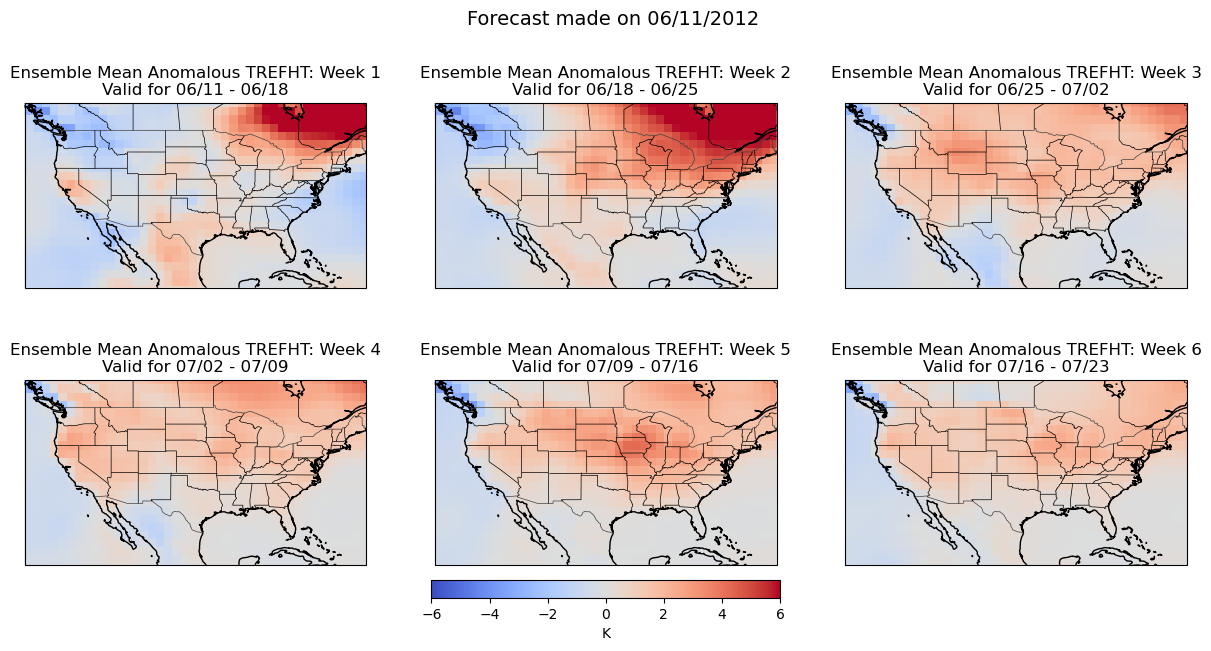

In [18]:
selDS = anom_0611_ensMean
startDate = datetime.datetime(2012,6,11)


fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.42,0.92,'Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


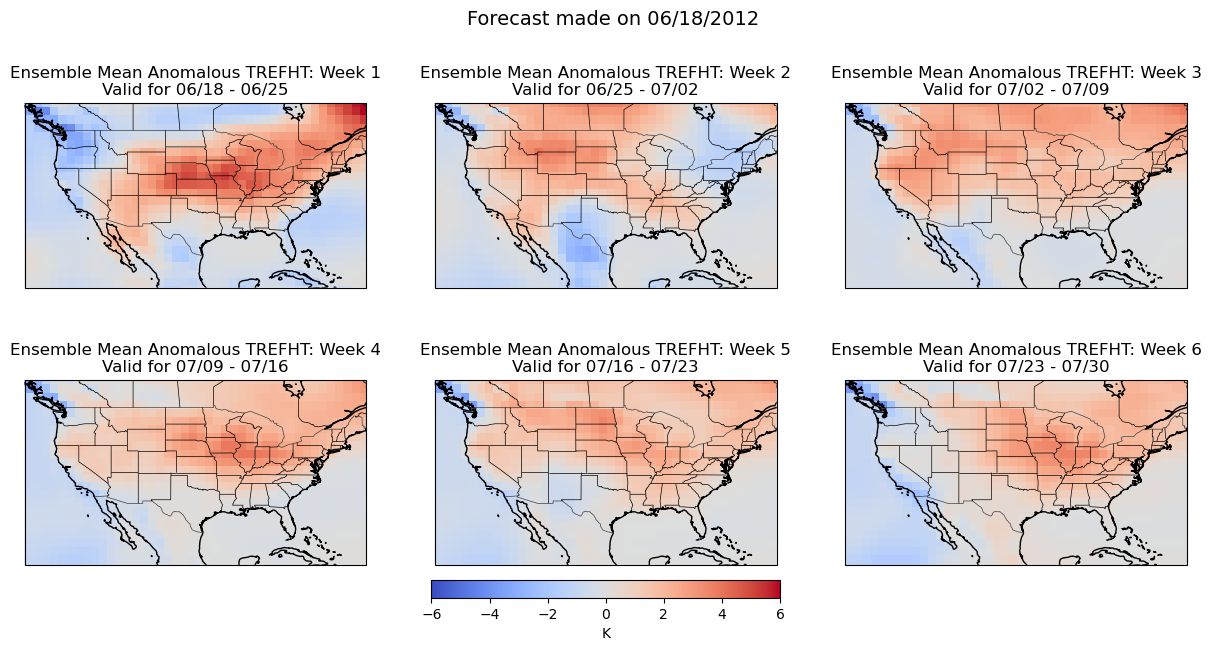

In [23]:
selDS = anom_0618_ensMean
startDate = datetime.datetime(2012,6,18)

fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]


fig.text(0.42,0.92,'Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


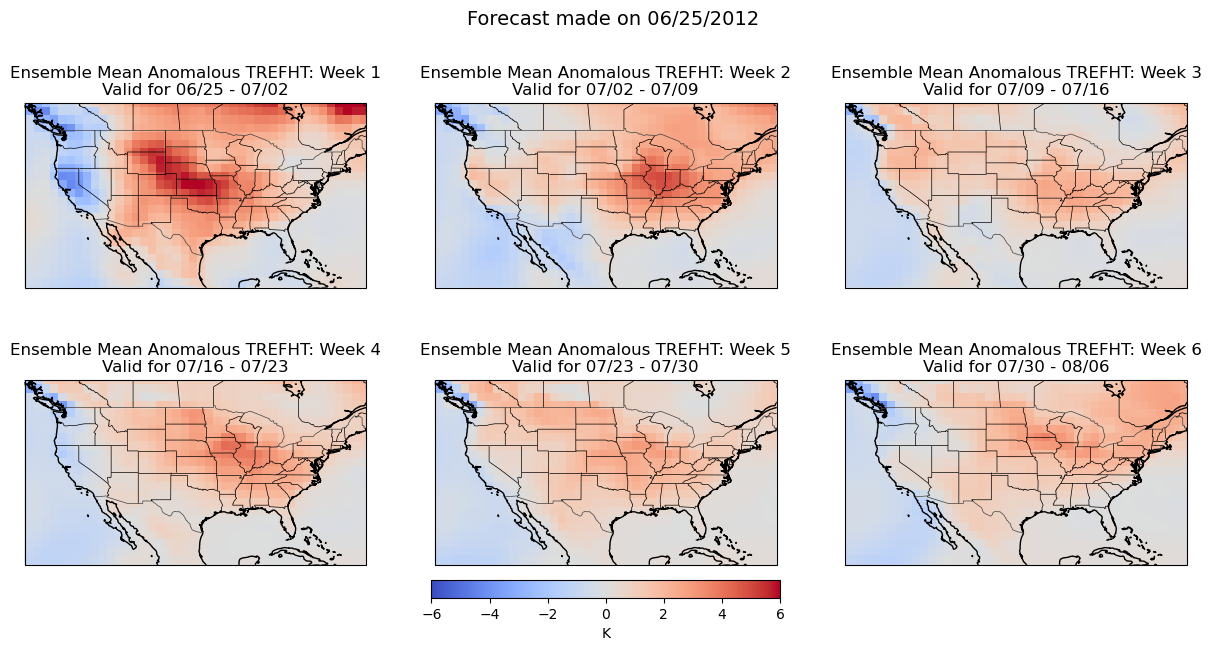

In [24]:
selDS = anom_0625_ensMean
startDate = datetime.datetime(2012,6,25)

fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]


fig.text(0.42,0.92,'Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


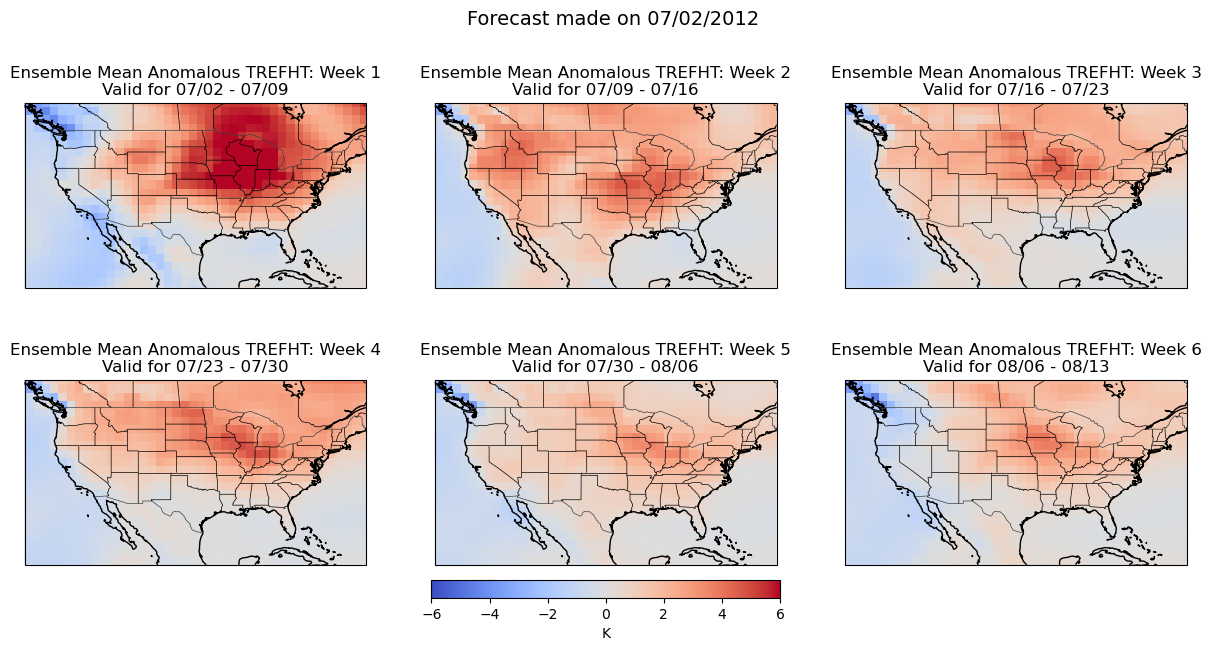

In [25]:
selDS = anom_0702_ensMean
startDate = datetime.datetime(2012,7,2)

fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]


fig.text(0.42,0.92,'Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 




## What about the climoLND case?

In [24]:
from tqdm import tqdm

In [135]:
'''
dateStr should look like: '2012-06-11'
'''

def get_climoRuns(dataDir, dateStr): 
    for iEns in tqdm(range(10)):
        listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6climoLND.'+dateStr+'.0'+str(iEns)+'/atm/hist/*.cam.h2.'+dateStr+'-*.nc'))[0]
        ensMember = int(listFiles_caseStudy.split('.')[4])  
    
        DS = xr.open_mfdataset(listFiles_caseStudy)
        DS = cesm_correct_time(DS)
        DS = DS.assign_coords({"ens":  iEns})
    
        if iEns==0:
            caseStudy_date_climo = DS
        else:
            caseStudy_date_climo = xr.concat([caseStudy_date_climo, DS], "ens")
    
    # caseStudy_date_climo['PRECT']       = caseStudy_date_climo.PRECC + caseStudy_date_climo.PRECL

    return caseStudy_date_climo
    

In [26]:
## CLIMO case
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoLND/archive/'

caseStudy_0611_climoLND = get_climoRuns(dataDir, '2012-06-11')


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


In [27]:
caseStudy_0618_climoLND = get_climoRuns(dataDir, '2012-06-18')
caseStudy_0625_climoLND = get_climoRuns(dataDir, '2012-06-25')
caseStudy_0702_climoLND = get_climoRuns(dataDir, '2012-07-02')


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


In [28]:
caseStudy_0611_climoLND = caseStudy_0611_climoLND.rename({'time': 'lead'})
caseStudy_0618_climoLND = caseStudy_0618_climoLND.rename({'time': 'lead'})
caseStudy_0625_climoLND = caseStudy_0625_climoLND.rename({'time': 'lead'})
caseStudy_0702_climoLND = caseStudy_0702_climoLND.rename({'time': 'lead'})


In [29]:
caseStudy_0611_climoLND["lead"] = range(0,46)
caseStudy_0618_climoLND["lead"] = range(0,46)
caseStudy_0625_climoLND["lead"] = range(0,46)
caseStudy_0702_climoLND["lead"] = range(0,46)


In [30]:
## - - - Get anomalies - - - 

# regrid first? 
regrid_climoLND_0611 = regrid_data(caseStudy_0611_climoLND.reindex(lat=list(reversed(caseStudy_0611_climoLND.lat))), climo_0611, method=1)
regrid_climoLND_0618 = regrid_data(caseStudy_0618_climoLND.reindex(lat=list(reversed(caseStudy_0618_climoLND.lat))), climo_0618, method=1)
regrid_climoLND_0625 = regrid_data(caseStudy_0625_climoLND.reindex(lat=list(reversed(caseStudy_0625_climoLND.lat))), climo_0625, method=1)
regrid_climoLND_0702 = regrid_data(caseStudy_0702_climoLND.reindex(lat=list(reversed(caseStudy_0702_climoLND.lat))), climo_0702, method=1)

# Compute actual anomalies
anom_climoLND_0611 = regrid_climoLND_0611['TREFHT'] - climo_0611['t2m']
anom_climoLND_0618 = regrid_climoLND_0618['TREFHT'] - climo_0618['t2m']
anom_climoLND_0625 = regrid_climoLND_0625['TREFHT'] - climo_0625['t2m']
anom_climoLND_0702 = regrid_climoLND_0702['TREFHT'] - climo_0702['t2m']

anom_climoLND_0611_ensMean = anom_climoLND_0611.mean(dim='ens')
anom_climoLND_0618_ensMean = anom_climoLND_0618.mean(dim='ens')
anom_climoLND_0625_ensMean = anom_climoLND_0625.mean(dim='ens')
anom_climoLND_0702_ensMean = anom_climoLND_0702.mean(dim='ens')


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [169]:
anom_v2_climoLND_0611 = regrid_climoLND_0611['TREFHT'] - climoLNDclimo_0611['t2m']
anom_v2_climoLND_0618 = regrid_climoLND_0618['TREFHT'] - climoLNDclimo_0618['t2m']


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [31]:
longrid_anom, latgrid_anom = np.meshgrid(anom_climoLND_0611_ensMean['lon'], anom_climoLND_0611_ensMean['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-6, vmax=6)

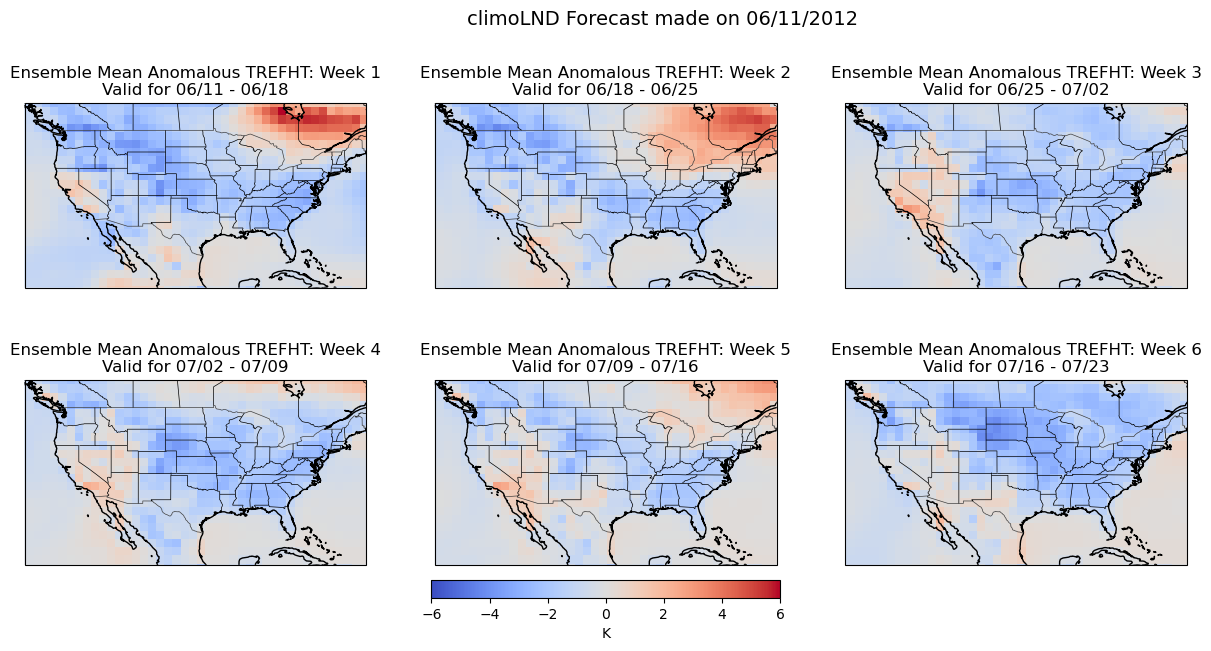

In [47]:
selDS = anom_climoLND_0611_ensMean
startDate = datetime.datetime(2012,6,11)


fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.42,0.92,'climoLND Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


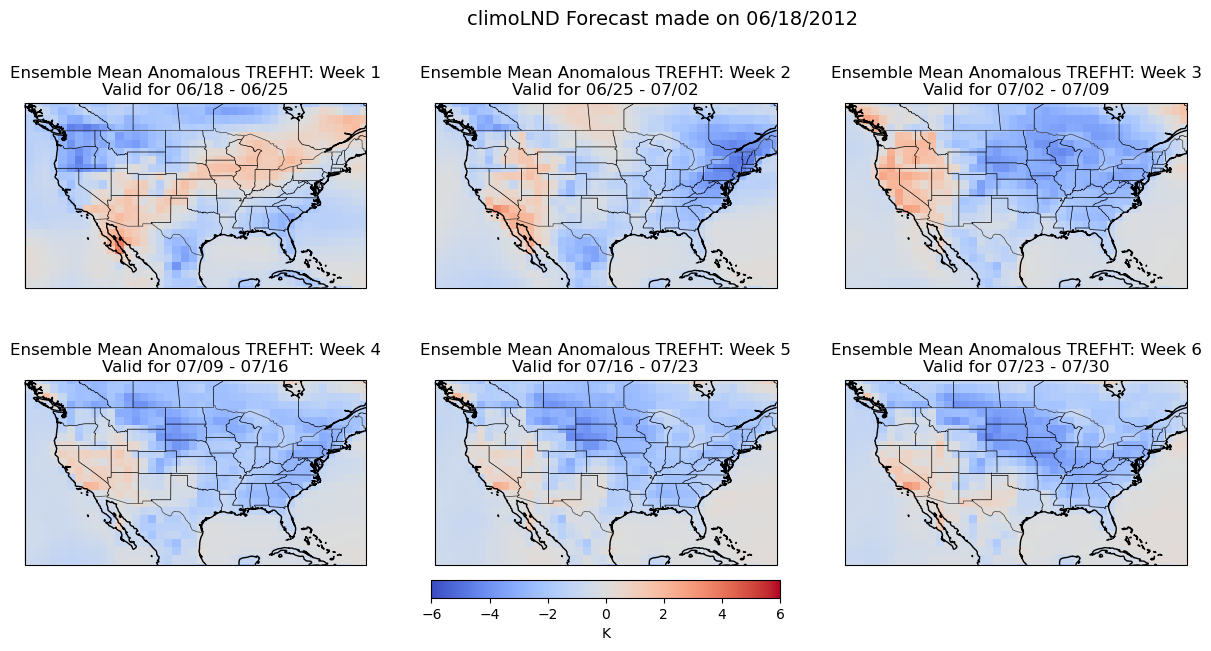

In [48]:
selDS = anom_climoLND_0618_ensMean
startDate = datetime.datetime(2012,6,18)


fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.42,0.92,'climoLND Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


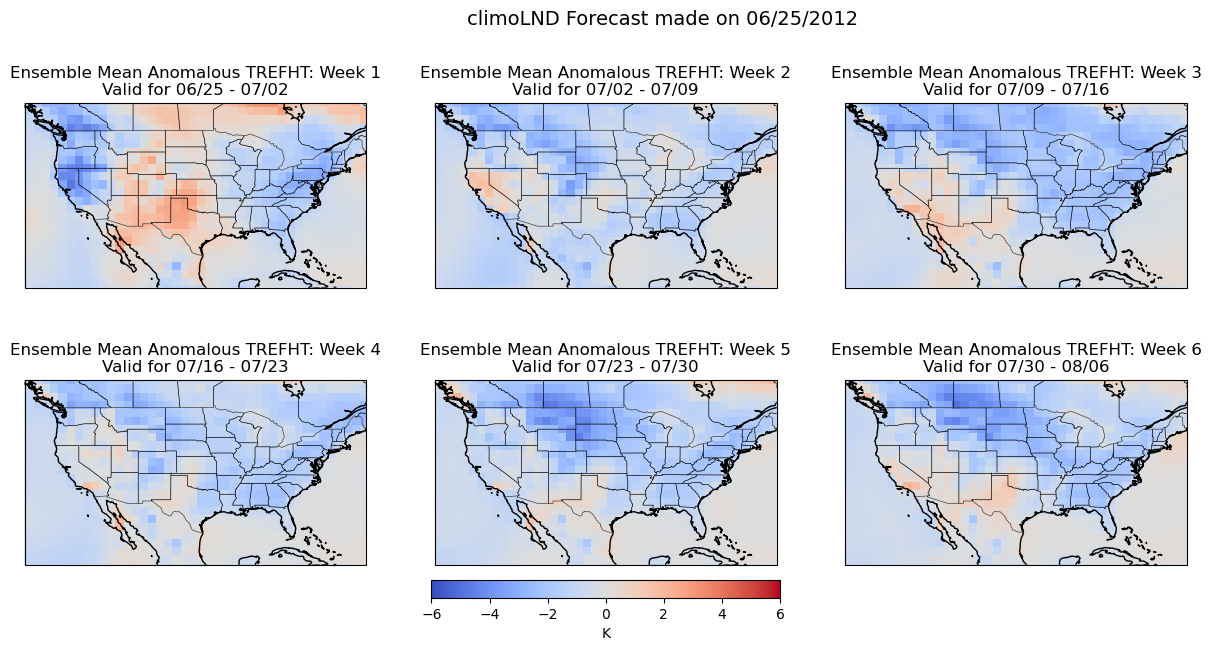

In [49]:
selDS = anom_climoLND_0625_ensMean
startDate = datetime.datetime(2012,6,25)

fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]


fig.text(0.42,0.92,'climoLND Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


## What about climoATMclimoOCN? 

In [137]:
def get_climoOCNATMRuns(dataDir, dateStr): 
    for iEns in tqdm(range(10)):
        listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6climoOCNclimoATM.'+dateStr+'.0'+str(iEns)+'/atm/hist/*.cam.h2.'+dateStr+'-*.nc'))[0]
        ensMember = int(listFiles_caseStudy.split('.')[4])  
    
        DS = xr.open_mfdataset(listFiles_caseStudy)
        DS = cesm_correct_time(DS)
        DS = DS.assign_coords({"ens":  iEns})
    
        if iEns==0:
            caseStudy_date_climo = DS
        else:
            caseStudy_date_climo = xr.concat([caseStudy_date_climo, DS], "ens")
    
    # caseStudy_date_climo['PRECT']       = caseStudy_date_climo.PRECC + caseStudy_date_climo.PRECL

    return caseStudy_date_climo
    

In [138]:
## CLIMO case
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoOCNclimoATM/archive/'

caseStudy_0611_climoATMOCN = get_climoOCNATMRuns(dataDir, '2012-06-11')
caseStudy_0618_climoATMOCN = get_climoOCNATMRuns(dataDir, '2012-06-18')


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


In [139]:
caseStudy_0611_climoATMOCN = caseStudy_0611_climoATMOCN.rename({'time': 'lead'})
caseStudy_0618_climoATMOCN = caseStudy_0618_climoATMOCN.rename({'time': 'lead'})

caseStudy_0611_climoATMOCN["lead"] = range(0,46)
caseStudy_0618_climoATMOCN["lead"] = range(0,46)


In [181]:
## - - - Get anomalies - - - 

# regrid first? 
regrid_climoATMOCN_0611 = regrid_data(caseStudy_0611_climoATMOCN.reindex(lat=list(reversed(caseStudy_0611_climoATMOCN.lat))), climo_0611, method=1)
regrid_climoATMOCN_0618 = regrid_data(caseStudy_0618_climoATMOCN.reindex(lat=list(reversed(caseStudy_0618_climoATMOCN.lat))), climo_0618, method=1)

# Compute actual anomalies
anom_climoATMOCN_0611 = regrid_climoATMOCN_0611['TREFHT'] - climo_0611['t2m']
anom_climoATMOCN_0618 = regrid_climoATMOCN_0618['TREFHT'] - climo_0618['t2m']

anom_v2_climoATMOCN_0611 = regrid_climoATMOCN_0611['TREFHT'] - climoATMOCNclimo_0611['TREFHT']
anom_v2_climoATMOCN_0618 = regrid_climoATMOCN_0618['TREFHT'] - climoATMOCNclimo_0618['TREFHT']


anom_climoATMOCN_0611_ensMean = anom_climoATMOCN_0611.mean(dim='ens')
anom_climoATMOCN_0618_ensMean = anom_climoATMOCN_0618.mean(dim='ens')


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [141]:
longrid_anom, latgrid_anom = np.meshgrid(anom_climoATMOCN_0611_ensMean['lon'], anom_climoATMOCN_0611_ensMean['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-6, vmax=6)

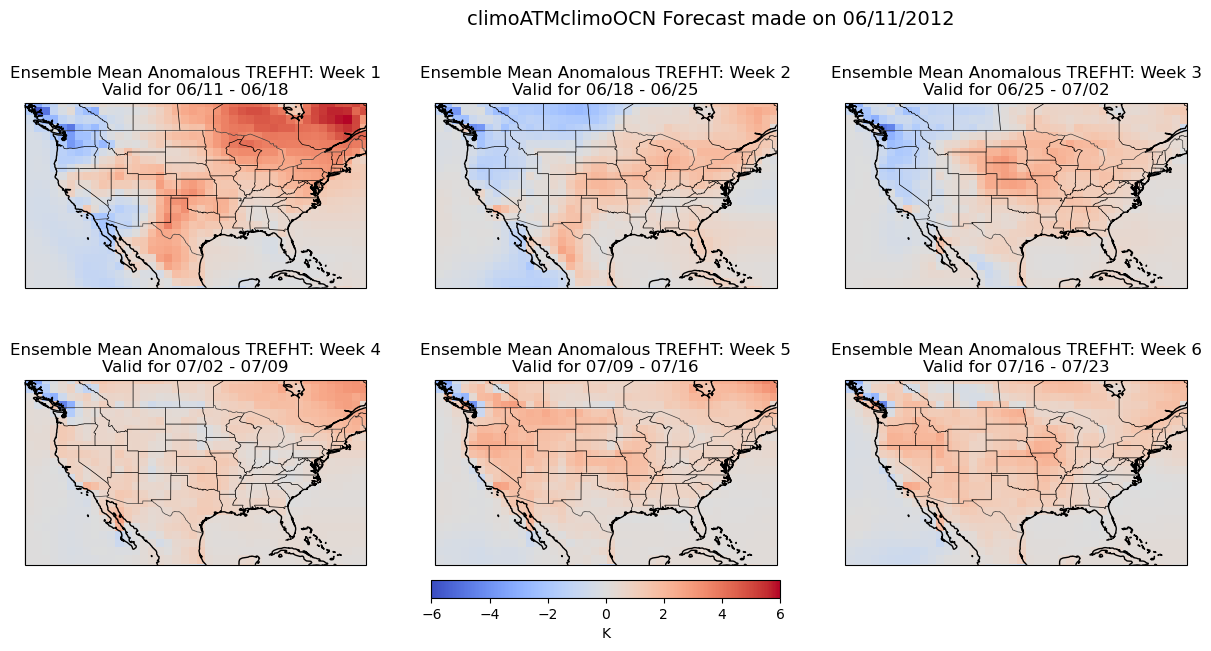

In [142]:
selDS = anom_climoATMOCN_0611_ensMean
startDate = datetime.datetime(2012,6,11)

fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.42,0.92,'climoATMclimoOCN Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


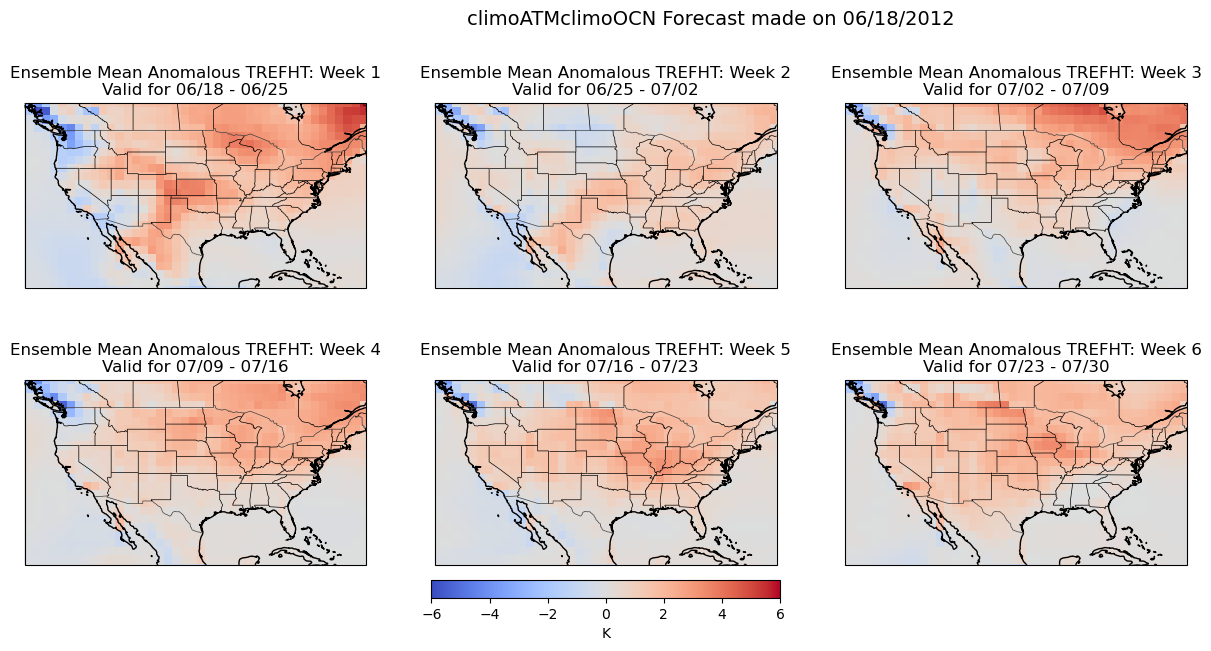

In [143]:
selDS = anom_climoATMOCN_0618_ensMean
startDate = datetime.datetime(2012,6,18)

fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.42,0.92,'climoATMclimoOCN Forecast made on '+startDate.strftime('%m/%d/%Y'),fontsize=14)
iStart    = 1
for iWeek in range(6): 
    selDS_thisWeek = selDS.isel(lead=slice(iStart, iStart+7))
    iStart = iStart+7

    p=axs[iWeek].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(selDS_thisWeek.mean(dim='lead').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
    axs[iWeek].set_title('Ensemble Mean Anomalous TREFHT: Week '+str(iWeek+1)+
                         '\nValid for '+(startDate+timedelta(days=iWeek*7)).strftime('%m/%d')+' - ' +
                         (startDate+timedelta(days=(iWeek*7)+7)).strftime('%m/%d'))
    
cb = fig.colorbar(p, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 


## What if we look at the evolution of some variable?

In [66]:
ERA5_mean = regrid_era5_2mT.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').VAR_2T

In [67]:
ERA5_clim = clim.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').VAR_2T
start_date = datetime.datetime(2012, 5, 1)
climDates = [start_date + datetime.timedelta(days=i) for i in range(len(clim.dayofyear.values))]

In [68]:
ctrlMean_0611 = ds_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').tas_2m
start_date = datetime.datetime(2012, 6, 11)
dates_0611 = [start_date + datetime.timedelta(days=i) for i in range(len(ctrlMean_0611.lead.values))]

In [69]:
ctrlMean_0618 = ds_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').tas_2m
start_date = datetime.datetime(2012, 6, 18)
dates_0618 = [start_date + datetime.timedelta(days=i) for i in range(len(ctrlMean_0618.lead.values))]

In [148]:
climLndMean_0611 = caseStudy_0611_climoLND.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').TREFHT
climLndMean_0618 = caseStudy_0618_climoLND.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').TREFHT


In [144]:
climATMOCNMean_0611 = caseStudy_0611_climoATMOCN.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').TREFHT
climATMOCNMean_0618 = caseStudy_0618_climoATMOCN.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').TREFHT


In [71]:
CTRLclimo_0611 = climo_0611.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').t2m
CTRLclimo_0618 = climo_0618.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').t2m


CLIMOLNDclimo_0611 = climoLNDclimo_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').t2m

Text(0.5, 1.0, '2m Temperature')

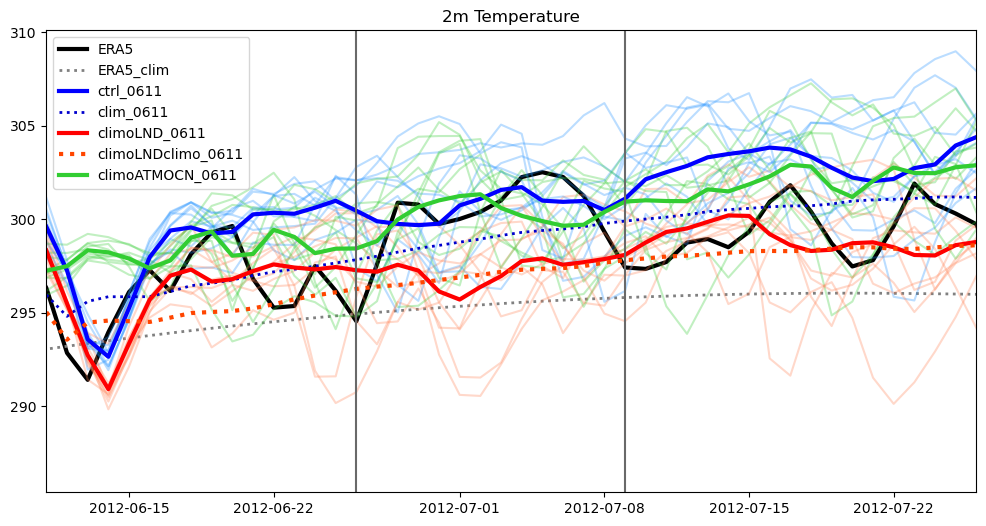

In [150]:
fig,axs=plt.subplots(1,1,figsize=(12,6))
axs.plot(ERA5_mean.time, ERA5_mean, 'k-', label='ERA5',linewidth=3)
axs.plot(climDates, ERA5_clim, ':',color='gray', label='ERA5_clim',linewidth=2)
axs.set_xlim([dates_0611[0], dates_0611[-1]])

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, ctrlMean_0611.isel(member=iEns), color='dodgerblue',alpha=0.3)
    axs.plot(dates_0611, climLndMean_0611.isel(ens=iEns), color='coral',alpha=0.3)
    axs.plot(dates_0611, climATMOCNMean_0611.isel(ens=iEns), color='limegreen',alpha=0.3)

axs.plot(dates_0611, ctrlMean_0611.mean(dim='member').values, color='blue', label='ctrl_0611', linewidth=3)
axs.plot(dates_0611, CTRLclimo_0611, ':', color='mediumblue', label='clim_0611', linewidth=2)
axs.plot(dates_0611, climLndMean_0611.mean(dim='ens').values, color='red', label='climoLND_0611', linewidth=3)
axs.plot(dates_0611, CLIMOLNDclimo_0611, ':', color='orangered', label='climoLNDclimo_0611', linewidth=3)
axs.plot(dates_0611, climATMOCNMean_0611.mean(dim='ens').values, color='limegreen', label='climoATMOCN_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('2m Temperature')

Text(0.5, 1.0, '2m Temperature')

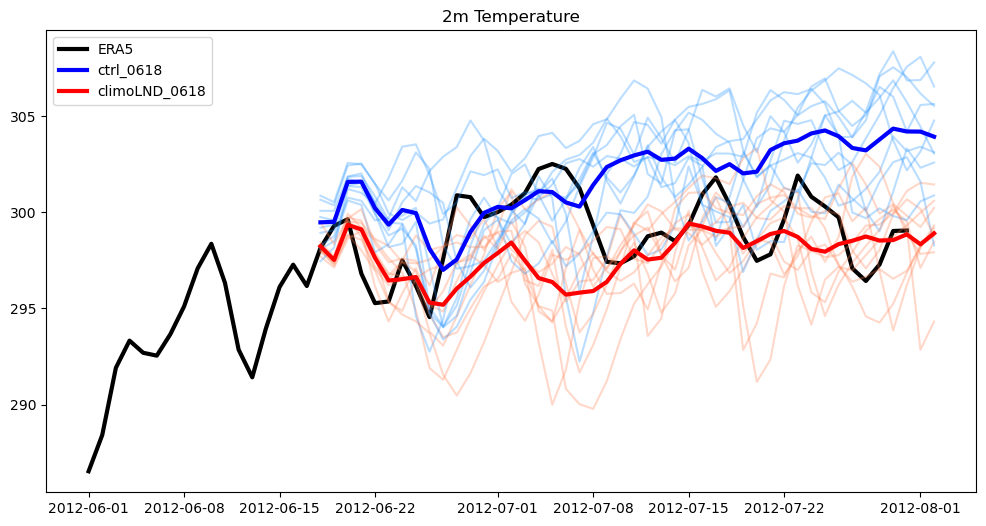

In [112]:
fig,axs=plt.subplots(1,1,figsize=(12,6))
axs.plot(ERA5_mean.time, ERA5_mean, 'k-', label='ERA5',linewidth=3)

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0618, ctrlMean_0618.isel(member=iEns), color='dodgerblue',alpha=0.3)
    axs.plot(dates_0618, climLndMean_0618.isel(ens=iEns), color='coral',alpha=0.3)

axs.plot(dates_0618, ctrlMean_0618.mean(dim='member').values, color='blue', label='ctrl_0618', linewidth=3)
axs.plot(dates_0618, climLndMean_0618.mean(dim='ens').values, color='red', label='climoLND_0618', linewidth=3)

axs.legend()
axs.set_title('2m Temperature')

### Temperature Anomalies

In [157]:
ERA5_anom_mean = era5_2T_anom.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').VAR_2T

In [159]:
anom_0611_mean = anom_0611.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')

In [172]:
anom_climoLND_0611_mean = anom_climoLND_0611.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
anom_v2_climoLND_0611_mean = anom_v2_climoLND_0611.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')

In [182]:
anom_climoATMOCN_0611_mean = anom_climoATMOCN_0611.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
anom_v2_climoATMOCN_0611_mean = anom_v2_climoATMOCN_0611.sel(lat=slice(47,37), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')

In [ ]:
fig,axs=plt.subplots(1,1,figsize=(12,6))
axs.plot(ERA5_mean.time, ERA5_anom_mean, 'k-', label='ERA5',linewidth=3)
axs.set_xlim([dates_0611[0], dates_0611[-1]])

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, anom_0611_mean.isel(member=iEns), color='dodgerblue',alpha=0.3)
    axs.plot(dates_0611, anom_climoLND_0611_mean.isel(ens=iEns), color='coral',alpha=0.3)
    axs.plot(dates_0611, anom_v2_climoLND_0611_mean.isel(ens=iEns), color='orange',alpha=0.3)
    axs.plot(dates_0611, anom_climoATMOCN_0611_mean.isel(ens=iEns), color='limegreen',alpha=0.3)
    axs.plot(dates_0611, anom_v2_climoATMOCN_0611_mean.isel(ens=iEns), color='teal',alpha=0.3)

axs.plot(dates_0611, anom_0611_mean.mean(dim='member').values, color='blue', label='ctrl_0611', linewidth=3)
axs.plot(dates_0611, anom_climoLND_0611_mean.mean(dim='ens').values, color='red', label='climoLND_0611', linewidth=3)
axs.plot(dates_0611, anom_v2_climoLND_0611_mean.mean(dim='ens').values, color='darkorange',linestyle='--', label='climoLND_v2_0611', linewidth=3)
axs.plot(dates_0611, anom_climoATMOCN_0611_mean.mean(dim='ens').values, color='limegreen', label='climoATMOCN_0611', linewidth=3)
axs.plot(dates_0611, anom_v2_climoATMOCN_0611_mean.mean(dim='ens').values, color='teal',linestyle='--', label='climoATMOCN_v2_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.axhline(0, color='dimgray',alpha=0.5)

axs.legend()
axs.set_title('2m Temperature Anomaly')

## What does the evolution of other variables look like? 

In [42]:
def get_allCAMdata(dataDir, dateStr): 
    for iEns in tqdm(range(10)):
        listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6v2.'+dateStr+'.0'+str(iEns)+'*.cam.h2.'+dateStr+'-*.nc'))[0]
        ensMember = int(listFiles_caseStudy.split('.')[2])  
    
        DS = xr.open_mfdataset(listFiles_caseStudy)
        DS = DS.assign_coords({"ens":  iEns})
    
        if iEns==0:
            caseStudy_date_LND = DS
        else:
            caseStudy_date_LND = xr.concat([caseStudy_date_LND, DS], "ens")
    
    return caseStudy_date_LND


In [44]:
## CTRL case
atmDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/'
allDS_0611 = get_allCAMdata(atmDir, '2012-06-11')
allDS_0618 = get_allCAMdata(atmDir, '2012-06-18')

 10%|█         | 1/10 [00:00<00:01,  6.86it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.00.cam.h2.2012-06-11-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.01.cam.h2.2012-06-11-00000.nc


 30%|███       | 3/10 [00:00<00:01,  5.62it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.02.cam.h2.2012-06-11-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.03.cam.h2.2012-06-11-00000.nc


 50%|█████     | 5/10 [00:00<00:00,  5.09it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.04.cam.h2.2012-06-11-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.05.cam.h2.2012-06-11-00000.nc


 70%|███████   | 7/10 [00:01<00:00,  5.36it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.06.cam.h2.2012-06-11-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.07.cam.h2.2012-06-11-00000.nc


 90%|█████████ | 9/10 [00:01<00:00,  5.80it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.08.cam.h2.2012-06-11-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-11.09.cam.h2.2012-06-11-00000.nc


 10%|█         | 1/10 [00:00<00:01,  7.38it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.00.cam.h2.2012-06-18-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.01.cam.h2.2012-06-18-00000.nc


 30%|███       | 3/10 [00:00<00:01,  6.72it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.02.cam.h2.2012-06-18-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.03.cam.h2.2012-06-18-00000.nc


 50%|█████     | 5/10 [00:00<00:00,  6.37it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.04.cam.h2.2012-06-18-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.05.cam.h2.2012-06-18-00000.nc


 70%|███████   | 7/10 [00:01<00:00,  6.07it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.06.cam.h2.2012-06-18-00000.nc
/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.07.cam.h2.2012-06-18-00000.nc


 80%|████████  | 8/10 [00:01<00:00,  5.64it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.08.cam.h2.2012-06-18-00000.nc


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]

/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/daily/cesm2cam6v2.2012-06-18.09.cam.h2.2012-06-18-00000.nc


In [45]:
def get_lndData(dataDir, dateStr): 
    for iEns in tqdm(range(10)):
        listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6v2.'+dateStr+'.0'+str(iEns)+'*.clm2.h0.'+dateStr+'-*.nc'))[0]
        ensMember = int(listFiles_caseStudy.split('.')[2])  
    
        DS = xr.open_mfdataset(listFiles_caseStudy)
        DS = DS.assign_coords({"ens":  iEns})
    
        if iEns==0:
            caseStudy_date_LND = DS
        else:
            caseStudy_date_LND = xr.concat([caseStudy_date_LND, DS], "ens")
    
    return caseStudy_date_LND


In [46]:
'''
dateStr should look like: '2012-06-11'
'''

def get_lndData_climoRuns(dataDir, dateStr): 
    for iEns in tqdm(range(10)):
        listFiles_caseStudy = np.sort(glob.glob(dataDir+'cesm2cam6climoLND.'+dateStr+'.0'+str(iEns)+'/lnd/hist/*.clm2.h0.'+dateStr+'-*.nc'))[0]
        ensMember = int(listFiles_caseStudy.split('.')[4])  
    
        DS = xr.open_mfdataset(listFiles_caseStudy)
        DS = DS.assign_coords({"ens":  iEns})
    
        if iEns==0:
            caseStudy_date_climo = DS
        else:
            caseStudy_date_climo = xr.concat([caseStudy_date_climo, DS], "ens")
    
    # caseStudy_date_climo['PRECT']       = caseStudy_date_climo.PRECC + caseStudy_date_climo.PRECL

    return caseStudy_date_climo
    

In [124]:
## CTRL case
lndDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/'
lndDS_0611 = get_lndData(lndDir, '2012-06-11')
lndDS_0618 = get_lndData(lndDir, '2012-06-18')

## climoLND case... 
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoLND/archive/'
climoLND_lndDS_0611 = get_lndData_climoRuns(dataDir, '2012-06-11')
climoLND_lndDS_0618 = get_lndData_climoRuns(dataDir, '2012-06-18')


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


In [125]:
## Pick out region of interest
allDS_0611_mean = allDS_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
allDS_0618_mean = allDS_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')

climLndMean_0611 = caseStudy_0611_climoLND.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
climLndMean_0618 = caseStudy_0618_climoLND.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')


lndDS_0611_mean = lndDS_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
lndDS_0618_mean = lndDS_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')

climoLND_lndDS_0611_mean = climoLND_lndDS_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
climoLND_lndDS_0618_mean = climoLND_lndDS_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')

Text(0.5, 1.0, 'SOILWATER_10CM [06/18 init]')

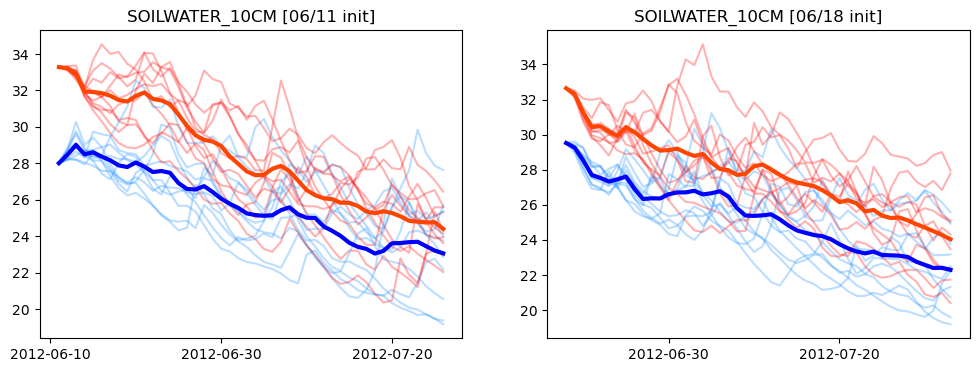

In [208]:
fig,axs = plt.subplots(1,2, figsize=(12,4))
axs = axs.ravel()

for iEns in range(len(lndDS_0611_mean.ens.values)):
    axs[0].plot(lndDS_0611_mean.time.values, lndDS_0611_mean.SOILWATER_10CM.isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[0].plot(climoLND_lndDS_0611_mean.time.values, climoLND_lndDS_0611_mean.SOILWATER_10CM.isel(ens=iEns),color='red',alpha=0.3)

    axs[1].plot(lndDS_0618_mean.time.values, lndDS_0618_mean.SOILWATER_10CM.isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[1].plot(climoLND_lndDS_0618_mean.time.values, climoLND_lndDS_0618_mean.SOILWATER_10CM.isel(ens=iEns),color='red',alpha=0.3)

axs[0].plot(lndDS_0611_mean.time.values, lndDS_0611_mean.SOILWATER_10CM.mean(dim='ens'), color='blue', linewidth=3)
axs[0].plot(climoLND_lndDS_0611_mean.time.values, climoLND_lndDS_0611_mean.SOILWATER_10CM.mean(dim='ens'), color='orangered', linewidth=3)

axs[1].plot(lndDS_0618_mean.time.values, lndDS_0618_mean.SOILWATER_10CM.mean(dim='ens'), color='blue', linewidth=3)
axs[1].plot(climoLND_lndDS_0618_mean.time.values, climoLND_lndDS_0618_mean.SOILWATER_10CM.mean(dim='ens'), color='orangered', linewidth=3)

axs[0].set_title('SOILWATER_10CM [06/11 init]')
axs[1].set_title('SOILWATER_10CM [06/18 init]')


Text(0.5, 1.0, 'RAIN [06/18 init]')

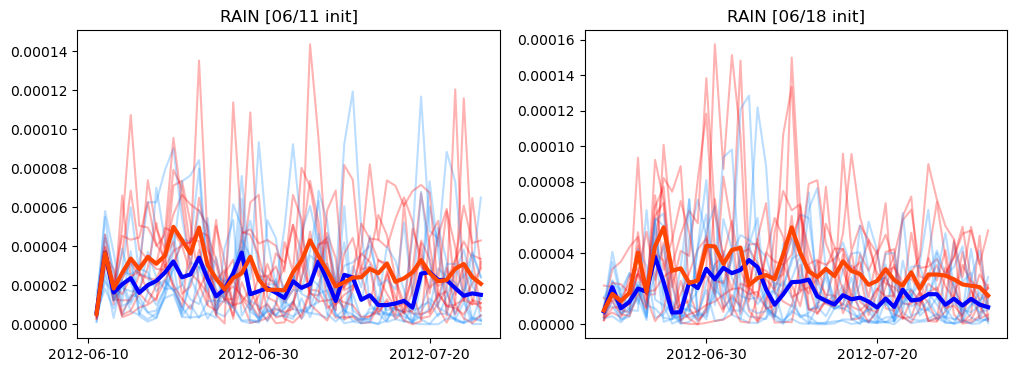

In [212]:

fig,axs = plt.subplots(1,2, figsize=(12,4))
axs = axs.ravel()

for iEns in range(len(lndDS_0611_mean.ens.values)):
    axs[0].plot(lndDS_0611_mean.time.values, lndDS_0611_mean.RAIN.isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[0].plot(climoLND_lndDS_0611_mean.time.values, climoLND_lndDS_0611_mean.RAIN.isel(ens=iEns),color='red',alpha=0.3)

    axs[1].plot(lndDS_0618_mean.time.values, lndDS_0618_mean.RAIN.isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[1].plot(climoLND_lndDS_0618_mean.time.values, climoLND_lndDS_0618_mean.RAIN.isel(ens=iEns),color='red',alpha=0.3)

axs[0].plot(lndDS_0611_mean.time.values, lndDS_0611_mean.RAIN.mean(dim='ens'), color='blue', linewidth=3)
axs[0].plot(climoLND_lndDS_0611_mean.time.values, climoLND_lndDS_0611_mean.RAIN.mean(dim='ens'), color='orangered', linewidth=3)

axs[1].plot(lndDS_0618_mean.time.values, lndDS_0618_mean.RAIN.mean(dim='ens'), color='blue', linewidth=3)
axs[1].plot(climoLND_lndDS_0618_mean.time.values, climoLND_lndDS_0618_mean.RAIN.mean(dim='ens'), color='orangered', linewidth=3)

axs[0].set_title('RAIN [06/11 init]')
axs[1].set_title('RAIN [06/18 init]')


Text(0.5, 1.0, 'QSOIL [06/18 init]')

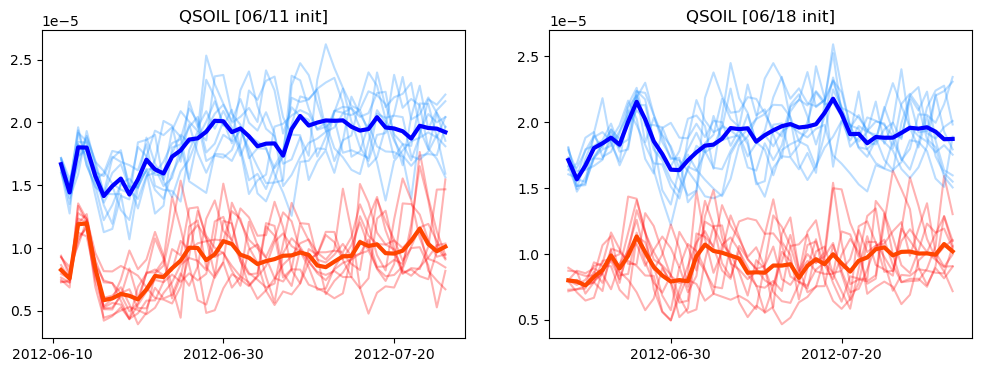

In [217]:
varSel = 'QSOIL'

fig,axs = plt.subplots(1,2, figsize=(12,4))
axs     = axs.ravel()

for iEns in range(len(lndDS_0611_mean.ens.values)):
    axs[0].plot(lndDS_0611_mean.time.values, lndDS_0611_mean[varSel].isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[0].plot(climoLND_lndDS_0611_mean.time.values, climoLND_lndDS_0611_mean[varSel].isel(ens=iEns),color='red',alpha=0.3)

    axs[1].plot(lndDS_0618_mean.time.values, lndDS_0618_mean[varSel].isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[1].plot(climoLND_lndDS_0618_mean.time.values, climoLND_lndDS_0618_mean[varSel].isel(ens=iEns),color='red',alpha=0.3)

axs[0].plot(lndDS_0611_mean.time.values, lndDS_0611_mean[varSel].mean(dim='ens'), color='blue', linewidth=3)
axs[0].plot(climoLND_lndDS_0611_mean.time.values, climoLND_lndDS_0611_mean[varSel].mean(dim='ens'), color='orangered', linewidth=3)

axs[1].plot(lndDS_0618_mean.time.values, lndDS_0618_mean[varSel].mean(dim='ens'), color='blue', linewidth=3)
axs[1].plot(climoLND_lndDS_0618_mean.time.values, climoLND_lndDS_0618_mean[varSel].mean(dim='ens'), color='orangered', linewidth=3)

axs[0].set_title(varSel+' [06/11 init]')
axs[1].set_title(varSel+' [06/18 init]')


Text(0.5, 1.0, 'U10 [06/18 init]')

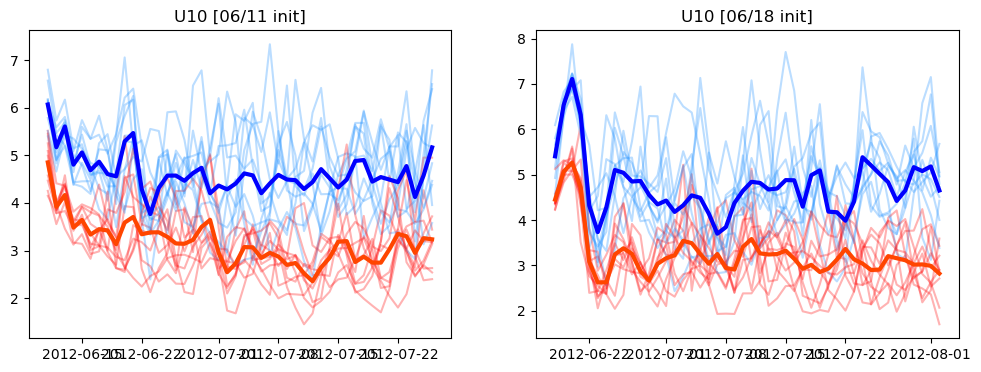

In [55]:
varSel = 'U10'

fig,axs = plt.subplots(1,2, figsize=(12,4))
axs     = axs.ravel()

for iEns in range(len(lndDS_0611_mean.ens.values)):
    axs[0].plot(dates_0611, allDS_0611_mean[varSel].isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[0].plot(dates_0611, climLndMean_0611[varSel].isel(ens=iEns),color='red',alpha=0.3)

    axs[1].plot(dates_0618, allDS_0618_mean[varSel].isel(ens=iEns),color='dodgerblue',alpha=0.3)
    axs[1].plot(dates_0618, climLndMean_0618[varSel].isel(ens=iEns),color='red',alpha=0.3)

axs[0].plot(dates_0611, allDS_0611_mean[varSel].mean(dim='ens'), color='blue', linewidth=3)
axs[0].plot(dates_0611, climLndMean_0611[varSel].mean(dim='ens'), color='orangered', linewidth=3)

axs[1].plot(dates_0618, allDS_0618_mean[varSel].mean(dim='ens'), color='blue', linewidth=3)
axs[1].plot(dates_0618, climLndMean_0618[varSel].mean(dim='ens'), color='orangered', linewidth=3)

axs[0].set_title(varSel+' [06/11 init]')
axs[1].set_title(varSel+' [06/18 init]')


In [121]:
dataDir_jun = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p2/hfls_sfc/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'hfls_sfc'

hfls_0611 = get_fcstDS(dataDir_jun, fcst_init[0])
hfls_0618 = get_fcstDS(dataDir_jun, fcst_init[1])

hfls_0611_mean = hfls_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
hfls_0618_mean = hfls_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')



In [122]:
dataDir_jun = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p2/hfss_sfc/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'hfss_sfc'

hfss_0611 = get_fcstDS(dataDir_jun, fcst_init[0])
hfss_0618 = get_fcstDS(dataDir_jun, fcst_init[1])

hfss_0611_mean = hfss_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')
hfss_0618_mean = hfss_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')


Text(0.5, 1.0, 'SHFLX [06/18 init]')

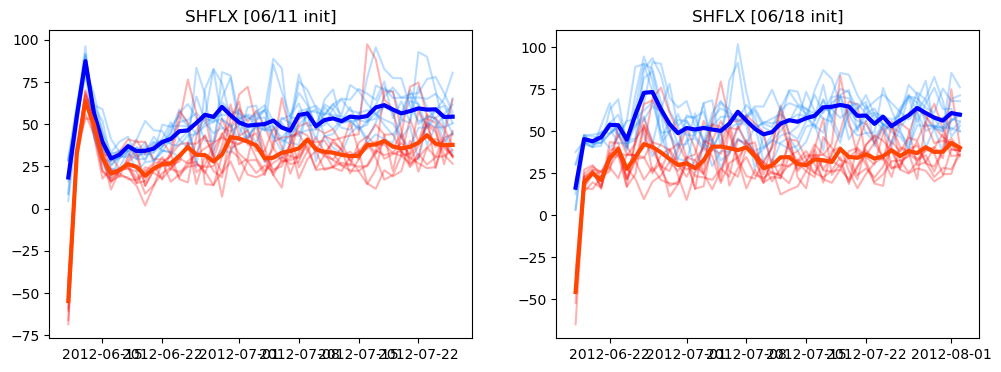

In [132]:
fig,axs = plt.subplots(1,2, figsize=(12,4))
axs     = axs.ravel()

for iEns in range(len(lndDS_0611_mean.ens.values)):
    axs[0].plot(dates_0611, hfss_0611_mean.isel(member=iEns).hfss_sfc.values,color='dodgerblue',alpha=0.3)
    axs[0].plot(dates_0611, climLndMean_0611['SHFLX'].isel(ens=iEns),color='red',alpha=0.3)

    axs[1].plot(dates_0618, hfss_0618_mean.isel(member=iEns).hfss_sfc.values,color='dodgerblue',alpha=0.3)
    axs[1].plot(dates_0618, climLndMean_0618['SHFLX'].isel(ens=iEns),color='red',alpha=0.3)

axs[0].plot(dates_0611, hfss_0611_mean.mean(dim='member').hfss_sfc.values, color='blue', linewidth=3)
axs[0].plot(dates_0611, climLndMean_0611['SHFLX'].mean(dim='ens'), color='orangered', linewidth=3)

axs[1].plot(dates_0618, hfss_0618_mean.mean(dim='member').hfss_sfc.values, color='blue', linewidth=3)
axs[1].plot(dates_0618, climLndMean_0618['SHFLX'].mean(dim='ens'), color='orangered', linewidth=3)

axs[0].set_title('SHFLX [06/11 init]')
axs[1].set_title('SHFLX [06/18 init]')


Text(0.5, 1.0, 'LHFLX [06/18 init]')

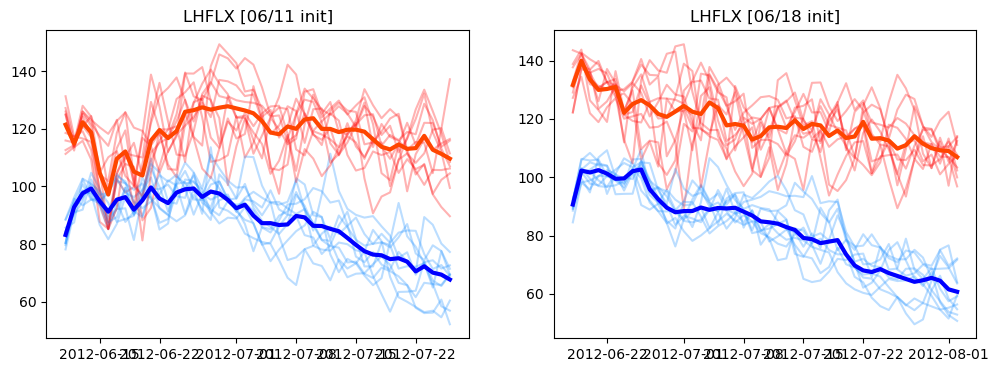

In [133]:
fig,axs = plt.subplots(1,2, figsize=(12,4))
axs     = axs.ravel()

for iEns in range(len(lndDS_0611_mean.ens.values)):
    axs[0].plot(dates_0611, hfls_0611_mean.isel(member=iEns).hfls_sfc.values,color='dodgerblue',alpha=0.3)
    axs[0].plot(dates_0611, climLndMean_0611['LHFLX'].isel(ens=iEns),color='red',alpha=0.3)

    axs[1].plot(dates_0618, hfls_0618_mean.isel(member=iEns).hfls_sfc.values,color='dodgerblue',alpha=0.3)
    axs[1].plot(dates_0618, climLndMean_0618['LHFLX'].isel(ens=iEns),color='red',alpha=0.3)

axs[0].plot(dates_0611, hfls_0611_mean.mean(dim='member').hfls_sfc.values, color='blue', linewidth=3)
axs[0].plot(dates_0611, climLndMean_0611['LHFLX'].mean(dim='ens'), color='orangered', linewidth=3)

axs[1].plot(dates_0618, hfls_0618_mean.mean(dim='member').hfls_sfc.values, color='blue', linewidth=3)
axs[1].plot(dates_0618, climLndMean_0618['LHFLX'].mean(dim='ens'), color='orangered', linewidth=3)

axs[0].set_title('LHFLX [06/11 init]')
axs[1].set_title('LHFLX [06/18 init]')


## Cases with varying coupling strength

In [63]:
dataDir_0p5 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land0.5/p1/tas_2m/2012/06/'
dataDir_1p0 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land1.0/p1/tas_2m/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'tas_2m'

tas_0p5_0611 = get_fcstDS(dataDir_0p5, fcst_init[0])
tas_0p5_0618 = get_fcstDS(dataDir_0p5, fcst_init[1])
tas_0p5_0625 = get_fcstDS(dataDir_0p5, fcst_init[2])

tas_1p0_0611 = get_fcstDS(dataDir_1p0, fcst_init[0])
tas_1p0_0618 = get_fcstDS(dataDir_1p0, fcst_init[1])
tas_1p0_0625 = get_fcstDS(dataDir_1p0, fcst_init[2])


In [64]:
tasMean_0p5_0611 = tas_0p5_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').tas_2m
tasMean_0p5_0618 = tas_0p5_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').tas_2m

tasMean_1p0_0611 = tas_1p0_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').tas_2m
tasMean_1p0_0618 = tas_1p0_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon').tas_2m



Text(0.5, 1.0, '2m Temperature')

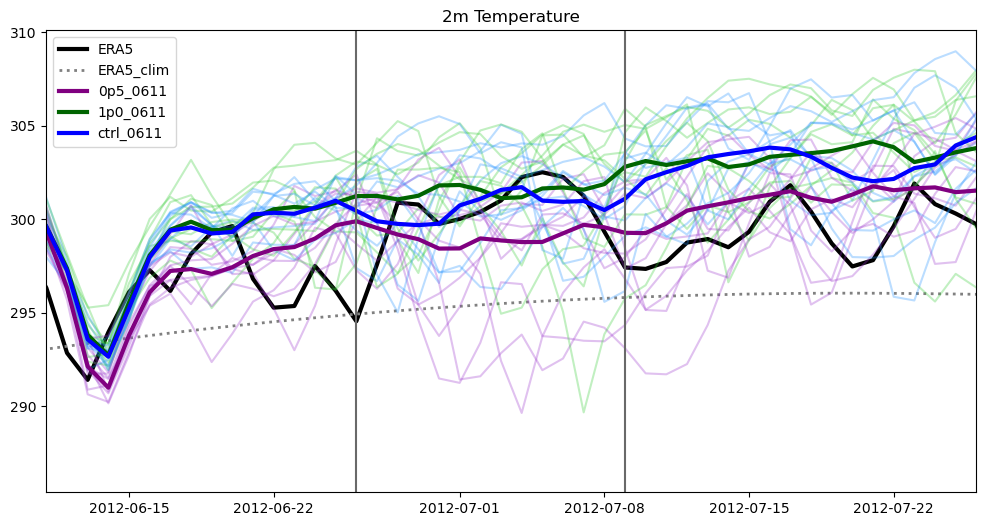

In [76]:
fig,axs=plt.subplots(1,1,figsize=(12,6))
axs.plot(ERA5_mean.time, ERA5_mean, 'k-', label='ERA5',linewidth=3)
axs.plot(climDates, ERA5_clim, ':',color='gray', label='ERA5_clim',linewidth=2)
axs.set_xlim([dates_0611[0], dates_0611[-1]])

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, tasMean_0p5_0611.isel(member=iEns), color='darkorchid',alpha=0.3)
    axs.plot(dates_0611, tasMean_1p0_0611.isel(member=iEns), color='limegreen',alpha=0.3)
    axs.plot(dates_0611, ctrlMean_0611.isel(member=iEns), color='dodgerblue',alpha=0.3)

axs.plot(dates_0611, tasMean_0p5_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
axs.plot(dates_0611, tasMean_1p0_0611.mean(dim='member').values, color='darkgreen', label='1p0_0611', linewidth=3)
axs.plot(dates_0611, ctrlMean_0611.mean(dim='member').values, color='blue', label='ctrl_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('2m Temperature')

In [112]:
from scipy import stats

ensemble1 = tasMean_0p5_0611
ensemble2 = tasMean_1p0_0611 

# Method 2: Day-by-day K-S tests
print(f"\n=== Day-by-Day K-S Test Results ===")
daily_ks_stats = []
daily_p_values = []

for day in range(46):
    day_data1 = ensemble1[:, day]  # 10 members for this day
    day_data2 = ensemble2[:, day]  # 10 members for this day
    
    ks_day, p_day = stats.ks_2samp(day_data1, day_data2)
    daily_ks_stats.append(ks_day)
    daily_p_values.append(p_day)

# Show first 10 days as example
for day in range(10):
    print(f"Day {day+1:2d}: K-S = {daily_ks_stats[day]:.3f}, p = {daily_p_values[day]:.4f}")

print("...")

# Count significant days
significant_days = sum(p < 0.05 for p in daily_p_values)
print(f"\nDays with significant differences (p < 0.05): {significant_days}/{45}")

# Method 3: Ensemble mean comparison
ensemble1_means = np.mean(ensemble1, axis=0)  # Mean across members for each day
ensemble2_means = np.mean(ensemble2, axis=0)  # Mean across members for each day

ks_means, p_means = stats.ks_2samp(ensemble1_means, ensemble2_means)
print(f"\n=== Ensemble Means K-S Test ===")
print(f"K-S Statistic: {ks_means:.4f}")
print(f"P-value: {p_means:.6f}")




=== Day-by-Day K-S Test Results ===
Day  1: K-S = 0.190, p = 0.8531
Day  2: K-S = 0.857, p = 0.0000
Day  3: K-S = 0.762, p = 0.0000
Day  4: K-S = 0.714, p = 0.0000
Day  5: K-S = 0.571, p = 0.0017
Day  6: K-S = 0.714, p = 0.0000
Day  7: K-S = 0.714, p = 0.0000
Day  8: K-S = 0.571, p = 0.0017
Day  9: K-S = 0.571, p = 0.0017
Day 10: K-S = 0.714, p = 0.0000
...

Days with significant differences (p < 0.05): 38/45

=== Ensemble Means K-S Test ===
K-S Statistic: 0.4783
P-value: 0.000039


In [110]:
# Method 1: Flatten all data points for overall comparison
data1_flat = (ensemble1.values).flatten()  # All 450 points
data2_flat = (ensemble2.values).flatten()  # All 450 points

# Perform two-sample K-S test
ks_stat, p_value = stats.ks_2samp(data1_flat, data2_flat)

print(f"\n=== Overall K-S Test Results ===")
print(f"K-S Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significant difference at α=0.05: {p_value < 0.05}")

# Effect size (using K-S statistic as effect size measure)
print(f"\nEffect Size (K-S statistic): {ks_stat:.4f}")
if ks_stat < 0.1:
    effect = "negligible"
elif ks_stat < 0.3:
    effect = "small"
elif ks_stat < 0.5:
    effect = "medium"
else:
    effect = "large"
print(f"Effect size interpretation: {effect}")


=== Overall K-S Test Results ===
K-S Statistic: 0.2702
P-value: 0.000000
Significant difference at α=0.05: True

Effect Size (K-S statistic): 0.2702
Effect size interpretation: small


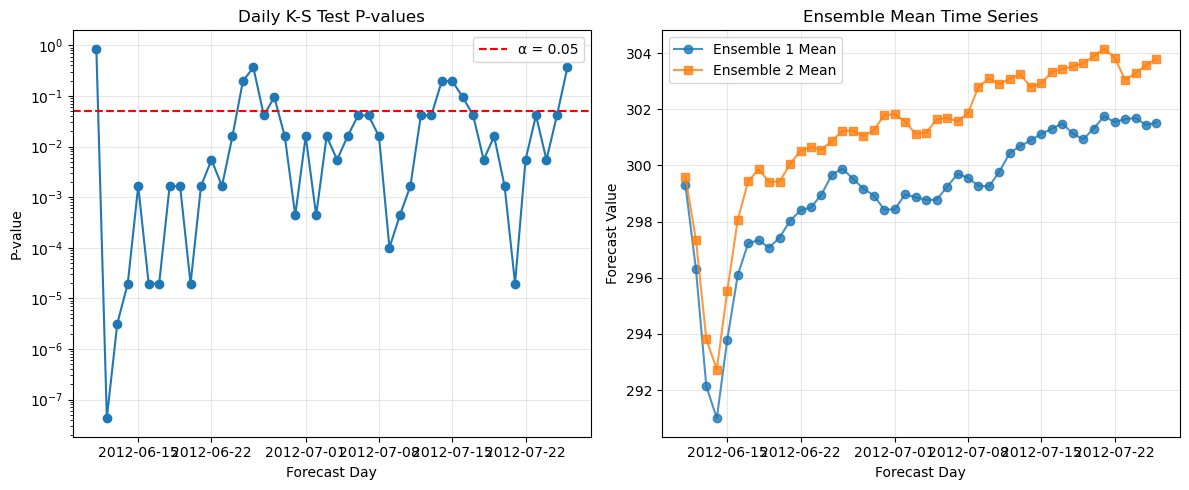

In [113]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
axes = axs.ravel()

# Plot 3: Daily p-values
axes[0].plot(dates_0611, daily_p_values, 'o-')
axes[0].axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
axes[0].set_title('Daily K-S Test P-values')
axes[0].set_xlabel('Forecast Day')
axes[0].set_ylabel('P-value')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 4: Time series of ensemble means
axes[1].plot(dates_0611, ensemble1_means, 'o-', label='DSL_0.5 Mean', alpha=0.8)
axes[1].plot(dates_0611, ensemble2_means, 's-', label='DSL_1.0 Mean', alpha=0.8)
axes[1].set_title('Ensemble Mean Time Series')
axes[1].set_xlabel('Forecast Day')
axes[1].set_ylabel('Forecast Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Text(0.5, 1.0, '2m Temperature')

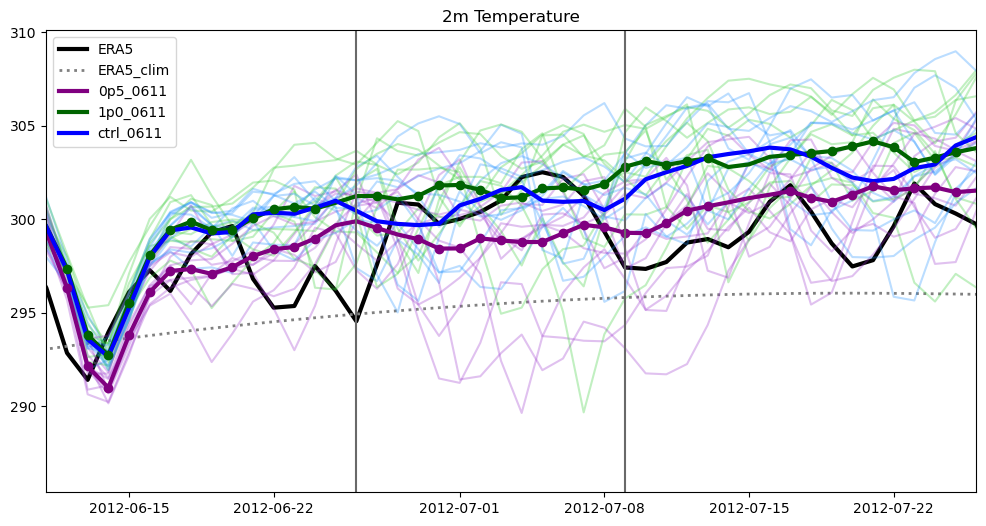

In [114]:
fig,axs=plt.subplots(1,1,figsize=(12,6))
axs.plot(ERA5_mean.time, ERA5_mean, 'k-', label='ERA5',linewidth=3)
axs.plot(climDates, ERA5_clim, ':',color='gray', label='ERA5_clim',linewidth=2)
axs.set_xlim([dates_0611[0], dates_0611[-1]])

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, tasMean_0p5_0611.isel(member=iEns), color='darkorchid',alpha=0.3)
    axs.plot(dates_0611, tasMean_1p0_0611.isel(member=iEns), color='limegreen',alpha=0.3)
    axs.plot(dates_0611, ctrlMean_0611.isel(member=iEns), color='dodgerblue',alpha=0.3)

axs.plot(dates_0611, tasMean_0p5_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
axs.plot(dates_0611, tasMean_1p0_0611.mean(dim='member').values, color='darkgreen', label='1p0_0611', linewidth=3)
axs.plot(dates_0611, ctrlMean_0611.mean(dim='member').values, color='blue', label='ctrl_0611', linewidth=3)

# Add sig test (K-S test, alpha=0.05)
for iDay in range(46): 
    if daily_p_values[iDay]<0.05:
        axs.plot(dates_0611[iDay], tasMean_0p5_0611.mean(dim='member').values[iDay],'o', color='purple',linewidth=3)
        axs.plot(dates_0611[iDay], tasMean_1p0_0611.mean(dim='member').values[iDay],'o', color='darkgreen', linewidth=3)


axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('2m Temperature')

In [91]:
dataDir_0p5 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land0.5/p2/hfls_sfc/2012/06/'
dataDir_1p0 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land1.0/p2/hfls_sfc/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'hfls_sfc'

lhf_0p5_0611 = get_fcstDS(dataDir_0p5, fcst_init[0])
lhf_0p5_0618 = get_fcstDS(dataDir_0p5, fcst_init[1])
lhf_0p5_0625 = get_fcstDS(dataDir_0p5, fcst_init[2])

lhf_1p0_0611 = get_fcstDS(dataDir_1p0, fcst_init[0])
lhf_1p0_0618 = get_fcstDS(dataDir_1p0, fcst_init[1])
lhf_1p0_0625 = get_fcstDS(dataDir_1p0, fcst_init[2])


In [92]:
lhfMean_0p5_0611 = lhf_0p5_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
lhfMean_0p5_0618 = lhf_0p5_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]

lhfMean_1p0_0611 = lhf_1p0_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
lhfMean_1p0_0618 = lhf_1p0_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]



Text(0.5, 1.0, 'LHFLX')

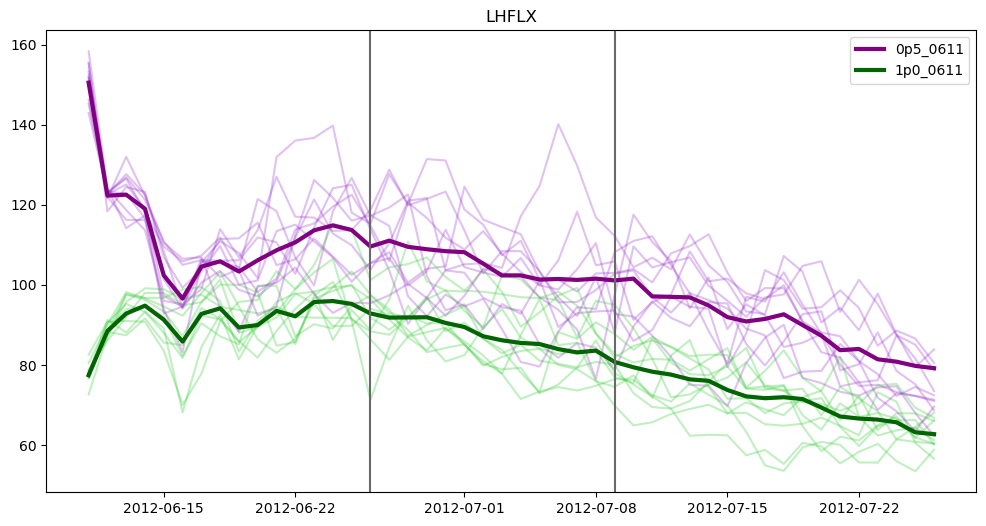

In [93]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, lhfMean_0p5_0611.isel(member=iEns), color='darkorchid',alpha=0.3)
    axs.plot(dates_0611, lhfMean_1p0_0611.isel(member=iEns), color='limegreen',alpha=0.3)

axs.plot(dates_0611, lhfMean_0p5_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
axs.plot(dates_0611, lhfMean_1p0_0611.mean(dim='member').values, color='darkgreen', label='1p0_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('LHFLX')

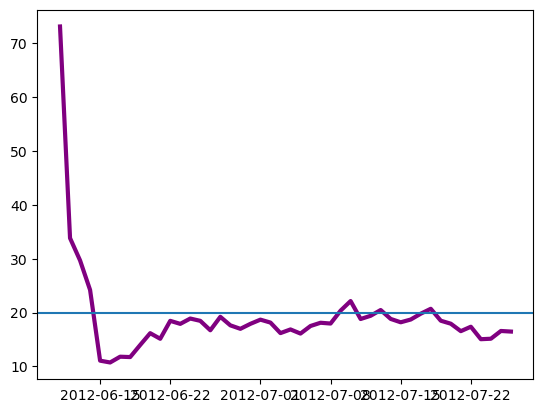

In [97]:
plt.plot(dates_0611, lhfMean_0p5_0611.mean(dim='member').values - lhfMean_1p0_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
plt.axhline(20)

In [88]:
dataDir_0p5 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land0.5/p2/hfss_sfc/2012/06/'
dataDir_1p0 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land1.0/p2/hfss_sfc/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'hfss_sfc'

shf_0p5_0611 = get_fcstDS(dataDir_0p5, fcst_init[0])
shf_0p5_0618 = get_fcstDS(dataDir_0p5, fcst_init[1])
shf_0p5_0625 = get_fcstDS(dataDir_0p5, fcst_init[2])

shf_1p0_0611 = get_fcstDS(dataDir_1p0, fcst_init[0])
shf_1p0_0618 = get_fcstDS(dataDir_1p0, fcst_init[1])
shf_1p0_0625 = get_fcstDS(dataDir_1p0, fcst_init[2])


In [89]:
shfMean_0p5_0611 = shf_0p5_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
shfMean_0p5_0618 = shf_0p5_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]

shfMean_1p0_0611 = shf_1p0_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
shfMean_1p0_0618 = shf_1p0_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]



Text(0.5, 1.0, 'SHFLX')

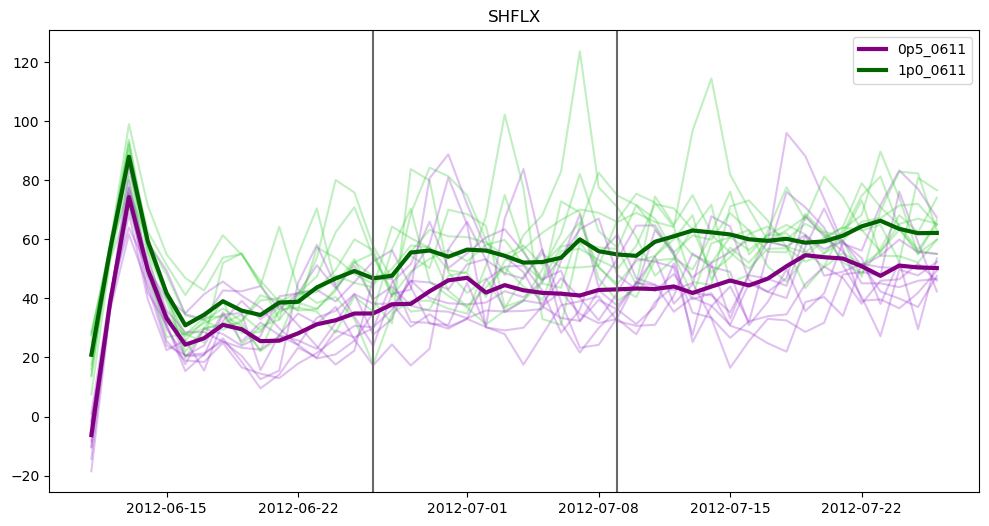

In [90]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, shfMean_0p5_0611.isel(member=iEns), color='darkorchid',alpha=0.3)
    axs.plot(dates_0611, shfMean_1p0_0611.isel(member=iEns), color='limegreen',alpha=0.3)

axs.plot(dates_0611, shfMean_0p5_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
axs.plot(dates_0611, shfMean_1p0_0611.mean(dim='member').values, color='darkgreen', label='1p0_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('SHFLX')

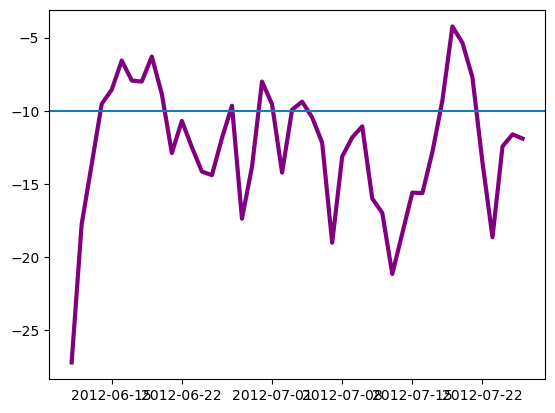

In [98]:
plt.plot(dates_0611, shfMean_0p5_0611.mean(dim='member').values - shfMean_1p0_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
plt.axhline(-10)

Text(0.5, 1.0, 'SHFLX+LHFLX')

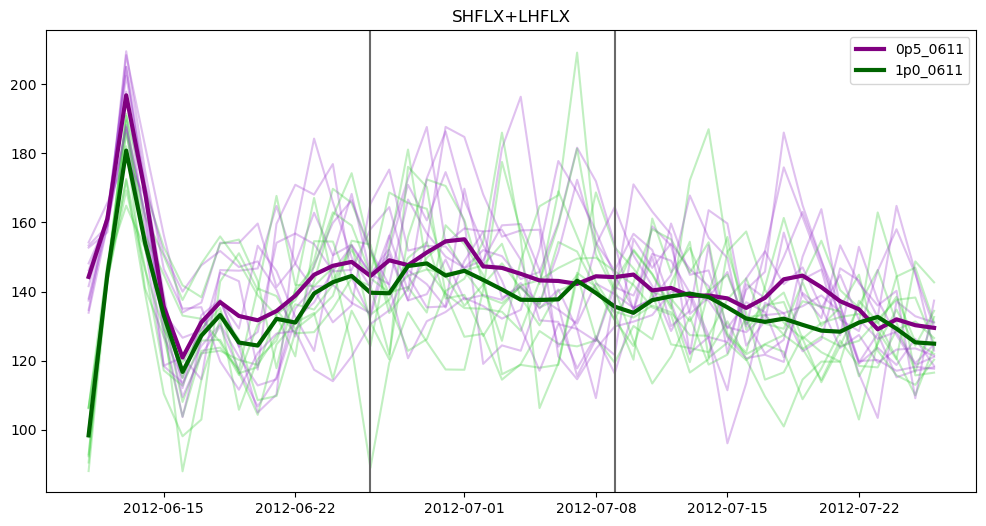

In [94]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, shfMean_0p5_0611.isel(member=iEns)+lhfMean_0p5_0611.isel(member=iEns), color='darkorchid',alpha=0.3)
    axs.plot(dates_0611, shfMean_1p0_0611.isel(member=iEns)+lhfMean_1p0_0611.isel(member=iEns), color='limegreen',alpha=0.3)

axs.plot(dates_0611, shfMean_0p5_0611.mean(dim='member').values+lhfMean_0p5_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
axs.plot(dates_0611, shfMean_1p0_0611.mean(dim='member').values+lhfMean_1p0_0611.mean(dim='member').values, color='darkgreen', label='1p0_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('SHFLX+LHFLX')

In [116]:
dataDir_0p5 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land0.5/p2/mrso/2012/06/'
dataDir_1p0 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land1.0/p2/mrso/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'mrso'

mrso_0p5_0611 = get_fcstDS(dataDir_0p5, fcst_init[0])
mrso_0p5_0618 = get_fcstDS(dataDir_0p5, fcst_init[1])
mrso_0p5_0625 = get_fcstDS(dataDir_0p5, fcst_init[2])

mrso_1p0_0611 = get_fcstDS(dataDir_1p0, fcst_init[0])
mrso_1p0_0618 = get_fcstDS(dataDir_1p0, fcst_init[1])
mrso_1p0_0625 = get_fcstDS(dataDir_1p0, fcst_init[2])


In [117]:
mrsoMean_0p5_0611 = mrso_0p5_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
mrsoMean_0p5_0618 = mrso_0p5_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]

mrsoMean_1p0_0611 = mrso_1p0_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
mrsoMean_1p0_0618 = mrso_1p0_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]



Text(0.5, 1.0, 'MRSO [soil liquid, 1m vertical-weighted averaged]')

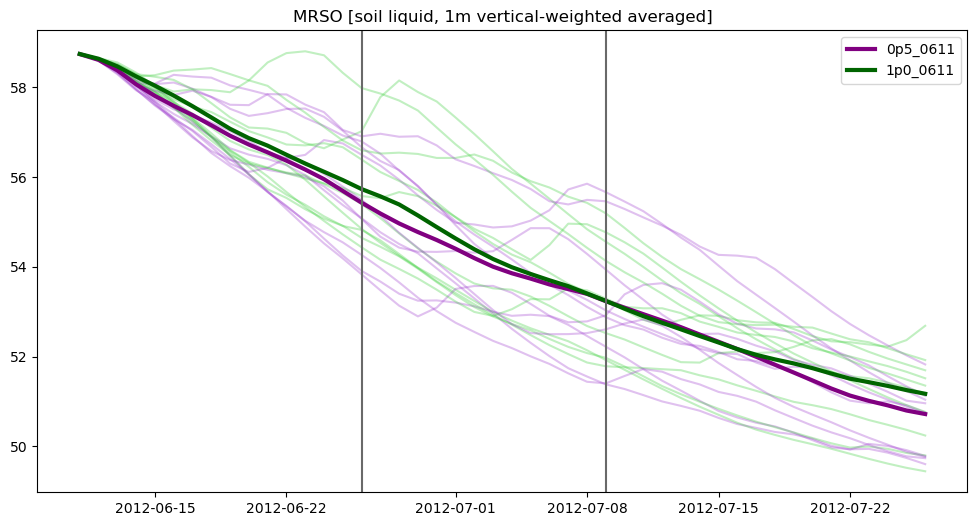

In [118]:
fig,axs=plt.subplots(1,1,figsize=(12,6))

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, mrsoMean_0p5_0611.isel(member=iEns), color='darkorchid',alpha=0.3)
    axs.plot(dates_0611, mrsoMean_1p0_0611.isel(member=iEns), color='limegreen',alpha=0.3)

axs.plot(dates_0611, mrsoMean_0p5_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
axs.plot(dates_0611, mrsoMean_1p0_0611.mean(dim='member').values, color='darkgreen', label='1p0_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('MRSO [soil liquid, 1m vertical-weighted averaged]')

Text(0.5, 1.0, 'pr_sfc')

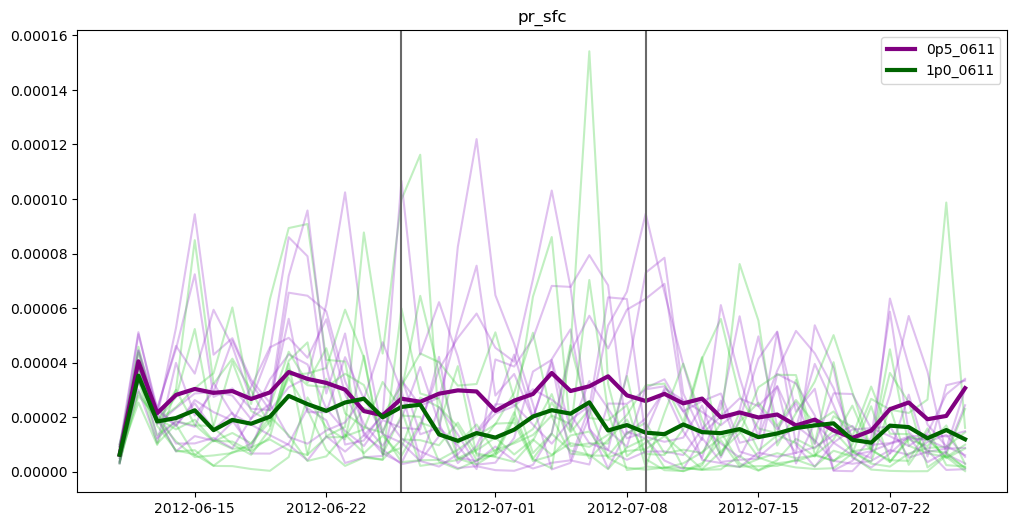

In [120]:
dataDir_0p5 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land0.5/p1/pr_sfc/2012/06/'
dataDir_1p0 = '/glade/work/mdfowler/S2S/runs_from_sasha/cesm2cam6_land1.0/p1/pr_sfc/2012/06/'

fcst_init = ['11jun2012',
             '18jun2012',
             '25jun2012',
            ]
var = 'pr_sfc'

pr_sfc_0p5_0611 = get_fcstDS(dataDir_0p5, fcst_init[0])
pr_sfc_0p5_0618 = get_fcstDS(dataDir_0p5, fcst_init[1])
pr_sfc_0p5_0625 = get_fcstDS(dataDir_0p5, fcst_init[2])

pr_sfc_1p0_0611 = get_fcstDS(dataDir_1p0, fcst_init[0])
pr_sfc_1p0_0618 = get_fcstDS(dataDir_1p0, fcst_init[1])
pr_sfc_1p0_0625 = get_fcstDS(dataDir_1p0, fcst_init[2])

## 

pr_sfcMean_0p5_0611 = pr_sfc_0p5_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
pr_sfcMean_0p5_0618 = pr_sfc_0p5_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]

pr_sfcMean_1p0_0611 = pr_sfc_1p0_0611.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]
pr_sfcMean_1p0_0618 = pr_sfc_1p0_0618.sel(lat=slice(37,47), lon=slice(263, 278)).mean(dim='lat').mean(dim='lon')[var]

## 

fig,axs=plt.subplots(1,1,figsize=(12,6))

for iEns in range(len(ctrlMean_0611.member.values)-1):
    axs.plot(dates_0611, pr_sfcMean_0p5_0611.isel(member=iEns), color='darkorchid',alpha=0.3)
    axs.plot(dates_0611, pr_sfcMean_1p0_0611.isel(member=iEns), color='limegreen',alpha=0.3)

axs.plot(dates_0611, pr_sfcMean_0p5_0611.mean(dim='member').values, color='purple', label='0p5_0611', linewidth=3)
axs.plot(dates_0611, pr_sfcMean_1p0_0611.mean(dim='member').values, color='darkgreen', label='1p0_0611', linewidth=3)

axs.axvline(datetime.datetime(2012, 6, 26), color='dimgray')
axs.axvline(datetime.datetime(2012, 7, 9), color='dimgray')

axs.legend()
axs.set_title('pr_sfc')



## Get soil moisture cases

In [4]:
%%time
ctrlDirs = np.sort(glob.glob('/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/cesm2cam6v2.2012-06-04.*'))
wetDirs  = np.sort(glob.glob('/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_highSM/lnd/hist/*'))
dryDirs  = np.sort(glob.glob('/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/*'))

for iEns in range(11): 
    keepVars = ['SOILWATER_10CM']
    
    ## Get DS in CTRL
    DS_lnd_ctrl_ens = xr.open_dataset(ctrlDirs[iEns])
    DS_lnd_ctrl_ens = DS_lnd_ctrl_ens.assign_coords({"ens":  iEns})

    if iEns==0:
        lndDS_ctrl = DS_lnd_ctrl_ens[keepVars]   
    else:
        lndDS_ctrl = xr.concat([lndDS_ctrl, DS_lnd_ctrl_ens[keepVars]], "ens")
    
    ## Get land DS in Dry
    DS_lnd_dry_ens = xr.open_dataset(dryDirs[iEns])
    DS_lnd_dry_ens = DS_lnd_dry_ens.assign_coords({"ens":  iEns})

    if iEns==0:
        lndDS_dry = DS_lnd_dry_ens[keepVars]
    else:
        lndDS_dry = xr.concat([lndDS_dry, DS_lnd_dry_ens[keepVars]], "ens")

    ## Get land DS in Wet
    DS_lnd_wet_ens = xr.open_dataset(wetDirs[iEns])
    DS_lnd_wet_ens = DS_lnd_wet_ens.assign_coords({"ens":  iEns})

    if iEns==0:
        lndDS_wet = DS_lnd_wet_ens[keepVars]
    else:
        lndDS_wet = xr.concat([lndDS_wet, DS_lnd_wet_ens[keepVars]], "ens")



CPU times: user 2.95 s, sys: 973 ms, total: 3.92 s
Wall time: 53.9 s


In [5]:
dryDirs

array(['/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/cesm2cam6_noahMP_lowSM_2012-06-04.00.clm2.h0.2012-06-04-00000.nc',
       '/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/cesm2cam6_noahMP_lowSM_2012-06-04.01.clm2.h0.2012-06-04-00000.nc',
       '/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/cesm2cam6_noahMP_lowSM_2012-06-04.02.clm2.h0.2012-06-04-00000.nc',
       '/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/cesm2cam6_noahMP_lowSM_2012-06-04.03.clm2.h0.2012-06-04-00000.nc',
       '/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/cesm2cam6_noahMP_lowSM_2012-06-04.04.clm2.h0.2012-06-04-00000.nc',
       '/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/cesm2cam6_noahMP_lowSM_2012-06-04.05.clm2.h0.2012-06-04-00000.nc',
       '/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2ca

In [6]:
longrid_anom, latgrid_anom = np.meshgrid(lndDS_ctrl['lon'], lndDS_ctrl['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=5, vmax=60)

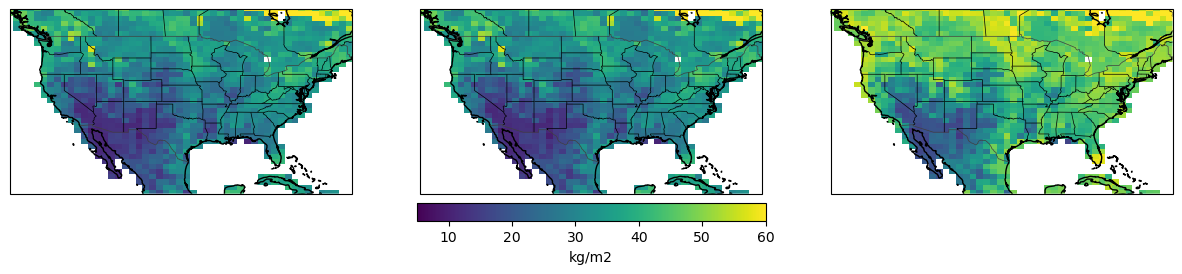

In [53]:
fig,axs = plt.subplots(1,3, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

axs[0].pcolormesh(longrid_anom, latgrid_anom, 
                lndDS_ctrl.mean(dim='ens').isel(time=0).SOILWATER_10CM.values, norm=normVar_anom)

p=axs[1].pcolormesh(longrid_anom, latgrid_anom, 
                lndDS_dry.mean(dim='ens').isel(time=0).SOILWATER_10CM.values, norm=normVar_anom)

axs[2].pcolormesh(longrid_anom, latgrid_anom, 
                lndDS_wet.mean(dim='ens').isel(time=0).SOILWATER_10CM.values, norm=normVar_anom)

cb = fig.colorbar(p, ax=axs, shrink=0.3, label='kg/m2', orientation='horizontal', pad=0.025) 



Text(0.5, 1.0, 'highSM - CTRL')

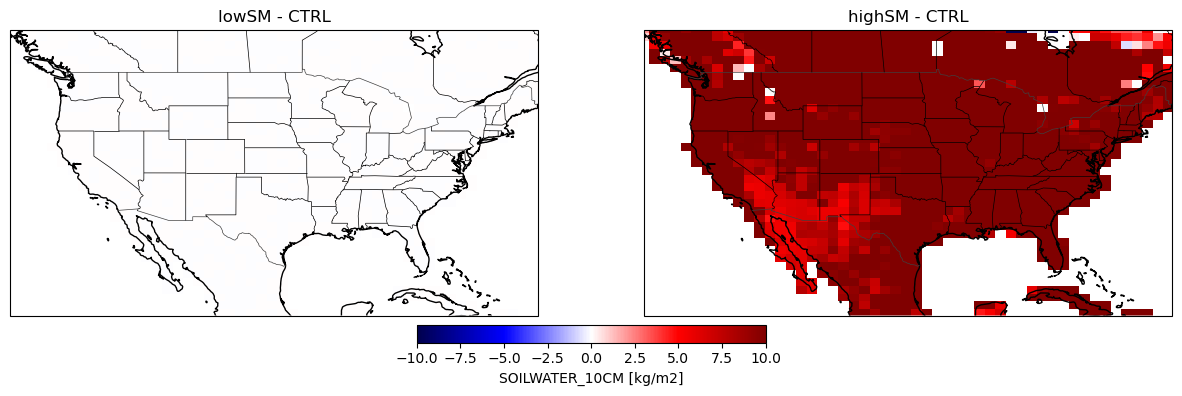

In [55]:
fig,axs = plt.subplots(1,2, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

normVar_anom  = matplotlib.colors.Normalize(vmin=-10, vmax=10)

[a.coastlines() for a in axs]
[a.set_extent([230,293,20,50]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

p=axs[0].pcolormesh(longrid_anom, latgrid_anom, 
                lndDS_dry.mean(dim='ens').isel(time=0).SOILWATER_10CM.values-lndDS_ctrl.mean(dim='ens').isel(time=0).SOILWATER_10CM.values, 
                    norm=normVar_anom, cmap='seismic')

axs[1].pcolormesh(longrid_anom, latgrid_anom, 
                lndDS_wet.mean(dim='ens').isel(time=0).SOILWATER_10CM.values-lndDS_ctrl.mean(dim='ens').isel(time=0).SOILWATER_10CM.values, 
                  norm=normVar_anom, cmap='seismic')

cb = fig.colorbar(p, ax=axs, shrink=0.3, label='SOILWATER_10CM [kg/m2]', orientation='horizontal', pad=0.025) 

axs[0].set_title('lowSM - CTRL') 
axs[1].set_title('highSM - CTRL')


In [14]:
## Test: 
datadir = '/glade/work/mdfowler/S2S/inputData/'
ctrlFile = 'I2000Clm50BgcCrop.002runContd.clm2.r.2012-06-04-00000.nc'
dryFile  = 'out_mult0p5.nc'
wetFile  = 'out_mult1p5.nc'

ctrl = xr.open_dataset(datadir+ctrlFile)
dry  = xr.open_dataset(datadir+dryFile)
wet = xr.open_dataset(datadir+wetFile)


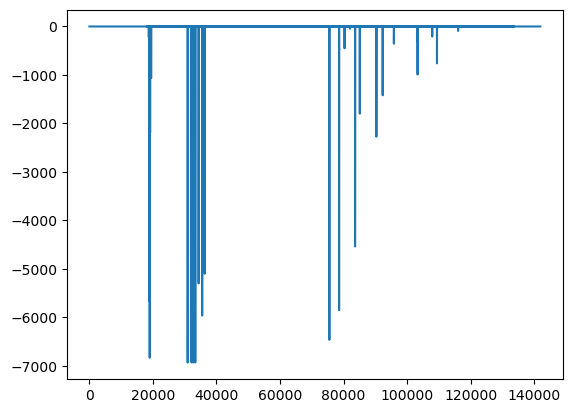

In [24]:
plt.plot(dry.H2OSOI_LIQ.isel(levtot=-1) - ctrl.H2OSOI_LIQ.isel(levtot=-1))

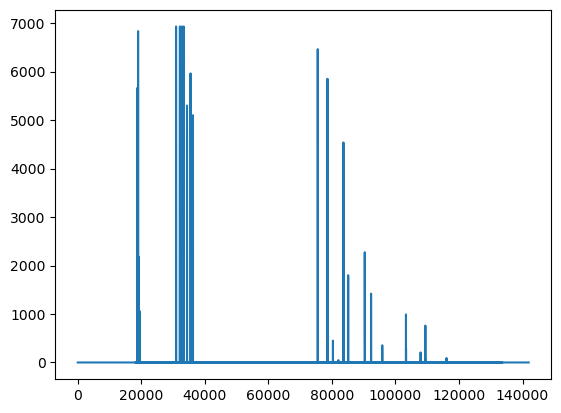

In [26]:
plt.plot(wet.H2OSOI_LIQ.isel(levtot=-1) - ctrl.H2OSOI_LIQ.isel(levtot=-1))

In [28]:
dryTest = '/glade/work/mdfowler/S2S/runs_from_sasha/archive/cesm2cam6_noahMP_lowSM/lnd/hist/cesm2cam6_noahMP_lowSM_2012-06-04.00.clm2.h0.2012-06-04-00000.nc'
ctrlTest = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/lnd/cesm2cam6v2.2012-06-04.00.clm2.h0.2012-06-04-00000.nc'

dryTest_DS  = xr.open_dataset(dryTest)
ctrlTest_DS = xr.open_dataset(ctrlTest)


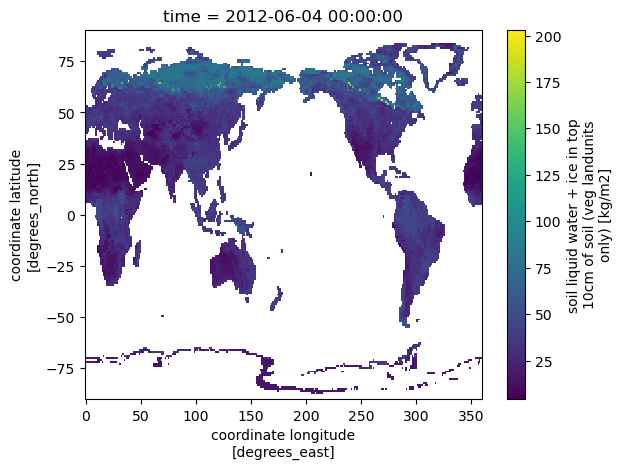

In [31]:
ctrlTest_DS.SOILWATER_10CM.isel(time=0).plot()

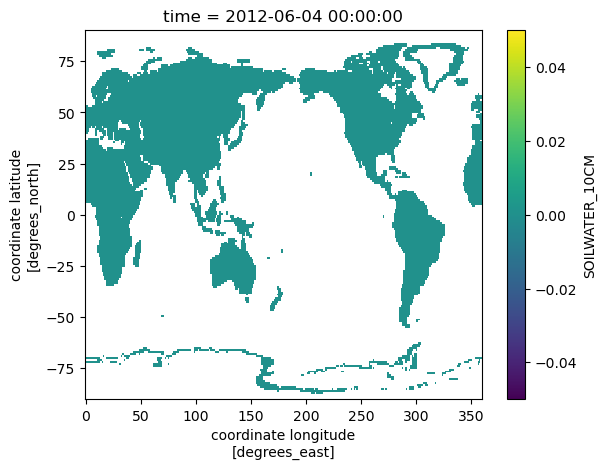

In [33]:
(dryTest_DS.SOILWATER_10CM.isel(time=0) - ctrlTest_DS.SOILWATER_10CM.isel(time=0)).plot()

In [ ]:
(dryTest_DS.H2OSOI.isel(time=0, levsoi=-1) - ctrlTest_DS.H2OSOI.isel(time=0)).plot()

In [34]:
dryTest_DS

<xarray.Dataset> Size: 975MB
Dimensions:         (levgrnd: 25, levlak: 10, levdcmp: 25, time: 46,
                     hist_interval: 2, lon: 288, lat: 192, levsoi: 20)
Coordinates:
  * levgrnd         (levgrnd) float32 100B 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levlak          (levlak) float32 40B 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp         (levdcmp) float32 100B 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * time            (time) object 368B 2012-06-04 00:00:00 ... 2012-07-19 00:...
  * lon             (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lat             (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval, levsoi
Data variables: (12/56)
    mcdate          (time) int32 184B ...
    mcsec           (time) int32 184B ...
    mdcur           (time) int32 184B ...
    mscur           (time) int32 184B ...
    nstep           (time) int32 184B ...
    time_bounds     (time, hist_interval) object 736B ...
    ...              ...
    SOILLIQ         (time, levsoi, lat, lon) float32 203MB ...
    SOILWATER_10CM  (time, lat, lon) float32 10MB ...
    TLAI            (time, lat, lon) float32 10MB ...
    TOTECOSYSC      (time, lat, lon) float32 10MB ...
    TOTVEGC         (time, lat, lon) float32 10MB ...
    TWS             (time, lat, lon) float32 10MB ...
Attributes: (12/100)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 05/29/25 22:23:23
    source:                                    Community Land Model CLM4.0
    hostname:                                  derecho
    ...                                        ...
    cft_irrigated_switchgrass:                 60
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          day_1